# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max Sharpe Ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, tablib, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import talib as ta
import requests
from io import StringIO
import time

In [2]:
# URL of the S&P 500 list on Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Add headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36'
}

# Fetch the HTML page
response = requests.get(url, headers=headers)

# Wrap the HTML content using StringIO
html = StringIO(response.text)

# Read tables
tables = pd.read_html(html)
sp500_table = tables[0]

# Clean ticker symbols
tickers = [ticker.replace('.', '-') for ticker in sp500_table['Symbol'].unique()]

In [3]:
START = dt.datetime.today() - dt.timedelta(days=365 * 10)
END = dt.datetime.today()

# Download data in batches
def download_in_batches(tickers, batch_size=100):
    all_data = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        data = yf.download(batch, start=START, end=END, auto_adjust=False)
        data.dropna(how='all', inplace=True)
        stacked = data.stack(level=1, future_stack=True)
        all_data.append(stacked)
        time.sleep(5)
    return pd.concat(all_data)

df = download_in_batches(tickers)
df.index.names = ['date', 'ticker']
df.columns = ['adj close', 'close', 'high', 'low', 'open', 'volume']
df

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  3 of 3 completed


adj close       close        high         low        open  \
date       ticker                                                               
2015-10-27 A        34.176071   37.049999   37.060001   36.470001   36.669998   
           AAPL     25.742317   28.637501   29.135000   28.497499   28.850000   
           ABBV     34.692131   52.580002   53.490002   52.009998   52.009998   
           ABNB           NaN         NaN         NaN         NaN         NaN   
           ABT      36.346325   43.880001   43.980000   43.500000   43.540001   
...                       ...         ...         ...         ...         ...   
2025-10-22 ZBRA    302.630005  302.630005  307.130005  299.209991  305.779999   
           ZTS     147.110001  147.110001  148.300003  145.729996  146.399994   
2025-10-23 ZBH     103.160004  103.160004  103.669998  101.809998  103.169998   
           ZBRA    313.890015  313.890015  314.390015  302.769989  302.769989   
           ZTS     146.389999  146.389999  147.509995  145.179993  146.000000   

                        volume  
date       ticker               
2015-10-27 A         2557200.0  
           AAPL    279537600.0  
           ABBV     11710800.0  
           ABNB            NaN  
           ABT       5743600.0  
...                        ...  
2025-10-22 ZBRA       399100.0  
           ZTS       2875400.0  
2025-10-23 ZBH       1126600.0  
           ZBRA       747500.0  
           ZTS       1565700.0  

[1264039 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
df['garma_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - ((2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2)
)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.RSI(x.values, timeperiod=20))

<Axes: xlabel='date'>

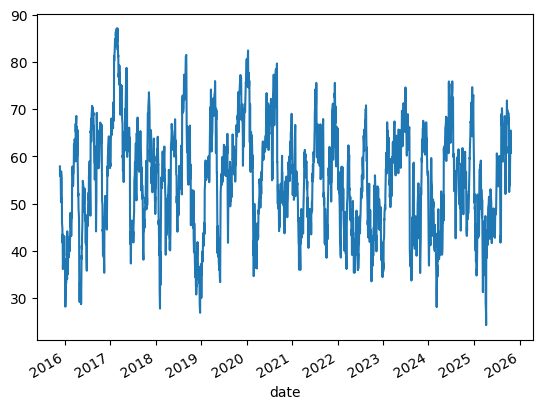

In [5]:
df.xs('AAPL', level=1)['rsi'].plot()

In [6]:
# Compute all BB bands per group
def compute_bbands(x):
    lower, middle, upper = ta.BBANDS(np.log1p(x), timeperiod=20)
    return pd.DataFrame({
        'bb_low': lower,
        'bb_mid': middle,
        'bb_high': upper
    }, index=x.index)

# Apply per symbol (level=1 in MultiIndex)
bb_df = df.groupby(level=1)['adj close'].apply(compute_bbands)

# Drop outer index to align with original df
bb_df.index = bb_df.index.droplevel(0)

# Join bands into df
df[['bb_low', 'bb_mid', 'bb_high']] = bb_df

In [7]:
def compute_atr(df):
    atr = ta.ATR(high=df['high'],
                    low=df['low'],
                    close=df['close'],
                    timeperiod=14)
    atr = atr - atr.mean()
    atr = atr / atr.std()
    return atr

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [8]:
def compute_macd(df):
    # Assuming ta.MACD returns a tuple of (macd_line, signal_line, histogram)
    macd, signal, histogram = ta.MACD(df['adj close'], 20)
    
    # Now normalize the macd line as intended
    macd = macd - macd.mean()
    macd = macd / macd.std()
    
    return macd

# Apply the function to each group in the DataFrame
df['macd'] = df.groupby(level=1, group_keys=False).apply(compute_macd)

In [9]:
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-10-27 A        34.176071   37.049999   37.060001   36.470001   36.669998   
           AAPL     25.742317   28.637501   29.135000   28.497499   28.850000   
           ABBV     34.692131   52.580002   53.490002   52.009998   52.009998   
           ABNB           NaN         NaN         NaN         NaN         NaN   
           ABT      36.346325   43.880001   43.980000   43.500000   43.540001   
...                       ...         ...         ...         ...         ...   
2025-10-22 ZBRA    302.630005  302.630005  307.130005  299.209991  305.779999   
           ZTS     147.110001  147.110001  148.300003  145.729996  146.399994   
2025-10-23 ZBH     103.160004  103.160004  103.669998  101.809998  103.169998   
           ZBRA    313.890015  313.890015  314.390015  302.769989  302.769989   
           ZTS     146.389999  146.389999  147.509995  145.179993  146.000000   

                        volume  garma_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-10-27 A         2557200.0        -0.001788        NaN       NaN   
           AAPL    279537600.0        -0.004773        NaN       NaN   
           ABBV     11710800.0        -0.062944        NaN       NaN   
           ABNB            NaN              NaN        NaN       NaN   
           ABT       5743600.0        -0.012537        NaN       NaN   
...                        ...              ...        ...       ...   
2025-10-22 ZBRA       399100.0         0.000300  49.592251  5.747202   
           ZTS       2875400.0         0.000144  51.579987  5.003560   
2025-10-23 ZBH       1126600.0         0.000164  57.021631  4.657648   
           ZBRA       747500.0         0.000207  54.542427  5.754328   
           ZTS       1565700.0         0.000124  50.029847  5.004274   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-10-27 A            NaN       NaN       NaN       NaN      87.395049  
           AAPL         NaN       NaN       NaN       NaN    7195.945568  
           ABBV         NaN       NaN       NaN       NaN     406.272608  
           ABNB         NaN       NaN       NaN       NaN            NaN  
           ABT          NaN       NaN       NaN       NaN     208.758752  
...                     ...       ...       ...       ...            ...  
2025-10-22 ZBRA    5.695221  5.643239  0.488516 -0.581034     120.779635  
           ZTS     4.977826  4.952092 -0.108606 -0.642828     423.000096  
2025-10-23 ZBH     4.609349  4.561049 -0.371622  0.133671     116.220060  
           ZBRA    5.697150  5.639973  0.525828 -0.442426     234.632786  
           ZTS     4.979643  4.955012 -0.127743 -0.568582     229.202822  

[1264039 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [10]:
last_column = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker', future_stack=True).to_frame('dollar_volume'),
    df.unstack()[last_column].resample('ME').last().stack('ticker', future_stack=True)
], axis=1).dropna()
data

dollar_volume   adj close  garma_klass_vol        rsi  \
date       ticker                                                          
2015-12-31 A          101.811329   38.672306        -0.002370  59.749728   
           AAPL      4222.775854   23.755869        -0.005234  38.059299   
           ABBV       274.525361   39.086376        -0.068133  58.544415   
           ABT        203.483528   37.199493        -0.014272  50.840517   
           ACGL        25.135179   22.108391        -0.001351  33.126675   
...                          ...         ...              ...        ...   
2025-10-31 XYZ        417.545112   78.559998         0.000656  54.676109   
           YUM        235.543955  146.369995         0.000156  49.220532   
           ZBH        123.658908  103.160004         0.000164  57.021631   
           ZBRA       158.346332  313.890015         0.000207  54.542427   
           ZTS        418.442174  146.389999         0.000124  50.029847   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-12-31 A       3.694887  3.662478  3.630068 -1.341618  0.222979  
           AAPL    3.336244  3.261253  3.186261 -1.091412 -0.547854  
           ABBV    3.705845  3.654628  3.603412 -1.022320 -0.254864  
           ABT     3.671007  3.645067  3.619126 -1.197082 -0.247579  
           ACGL    3.185731  3.154631  3.123531 -1.095823 -0.640896  
...                     ...       ...       ...       ...       ...  
2025-10-31 XYZ     4.406534  4.348369  4.290203 -0.329737  0.019860  
           YUM     5.051983  4.999479  4.946975  1.009132 -0.489263  
           ZBH     4.657648  4.609349  4.561049 -0.371622  0.133671  
           ZBRA    5.754328  5.697150  5.639973  0.525828 -0.442426  
           ZTS     5.004274  4.979643  4.955012 -0.127743 -0.568582  

[58271 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [11]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()
data['dollar_volume_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False, na_option='bottom')
data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)
data

adj close  garma_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2016-11-30 AAPL     25.497942        -0.002980  48.015343  3.301999  3.272940   
           ABBV     41.666466        -0.058998  49.727655  3.820083  3.746020   
           ABT      32.327568        -0.012528  39.665465  3.575240  3.538818   
           ACN     104.032501        -0.008727  54.807780  4.673460  4.649585   
           ADBE    102.809998         0.000156  42.513576  4.697545  4.665796   
...                       ...              ...        ...       ...       ...   
2025-10-31 WDAY    243.279999         0.000087  55.441651  5.520121  5.476313   
           WFC      84.459999         0.000208  54.830303  4.485036  4.424953   
           WMT     106.860001         0.000133  59.624636  4.702950  4.657172   
           XOM     115.980003         0.000070  58.539716  4.765502  4.736960   
           XYZ      78.559998         0.000656  54.676109  4.406534  4.348369   

                    bb_high       atr      macd  
date       ticker                                
2016-11-30 AAPL    3.243882 -1.135548 -0.327355  
           ABBV    3.671957 -0.766212 -0.341579  
           ABT     3.502396 -1.156439 -0.617311  
           ACN     4.625711 -1.144404  0.098596  
           ADBE    4.634046 -1.378950 -0.157853  
...                     ...       ...       ...  
2025-10-31 WDAY    5.432506  0.547134  0.339769  
           WFC     4.364871  2.827479  0.614778  
           WMT     4.611395  2.619994  1.711090  
           XOM     4.708418  0.356185  0.176864  
           XYZ     4.290203 -0.329737  0.019860  

[16092 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [12]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        pct_change = df['adj close'].pct_change(lag)
        clipped_pct_change = pct_change.clip(lower=pct_change.quantile(outlier_cutoff),
                                             upper=pct_change.quantile(1 - outlier_cutoff))
        df[f'return_{lag}m'] = (clipped_pct_change + 1).pow(1/lag) - 1
        
    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()
data

adj close  garma_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2017-11-30 AAPL     40.284882        -0.000978  57.636926  3.750123  3.724070   
           ABBV     68.843269        -0.043585  64.404090  4.249307  4.221257   
           ABT      48.977734        -0.006125  60.065340  3.913729  3.895599   
           ACN     131.527054        -0.004704  66.222649  4.894008  4.870755   
           ADBE    181.470001         0.000276  59.418081  5.230899  5.210247   
...                       ...              ...        ...       ...       ...   
2025-10-31 WDAY    243.279999         0.000087  55.441651  5.520121  5.476313   
           WFC      84.459999         0.000208  54.830303  4.485036  4.424953   
           WMT     106.860001         0.000133  59.624636  4.702950  4.657172   
           XOM     115.980003         0.000070  58.539716  4.765502  4.736960   
           XYZ      78.559998         0.000656  54.676109  4.406534  4.348369   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2017-11-30 AAPL    3.698016 -1.027242  0.007104   0.020278   0.057851   
           ABBV    4.193207 -0.578487  0.229570   0.073906   0.048005   
           ABT     3.877469 -1.218267  0.096862   0.039461   0.030329   
           ACN     4.847501 -1.122346  0.362687   0.039688   0.051863   
           ADBE    5.189594 -1.120716  0.428963   0.036024   0.102928   
...                     ...       ...       ...        ...        ...   
2025-10-31 WDAY    5.432506  0.547134  0.339769   0.010593   0.026636   
           WFC     4.364871  2.827479  0.614778   0.007635   0.013777   
           WMT     4.611395  2.619994  1.711090   0.036872   0.049703   
           XOM     4.708418  0.356185  0.176864   0.028647   0.007366   
           XYZ     4.290203 -0.329737  0.019860   0.087035  -0.006804   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2017-11-30 AAPL     0.016923   0.021096   0.026836    0.038851  
           ABBV     0.090300   0.068909   0.054211    0.042732  
           ABT      0.036023   0.037540   0.027025    0.035227  
           ACN      0.045524   0.030945   0.023509    0.019735  
           ADBE     0.053598   0.041895   0.048650    0.048490  
...                      ...        ...        ...         ...  
2025-10-31 WDAY     0.019805  -0.001174  -0.008228    0.003300  
           WFC      0.017574   0.031277   0.009559    0.024045  
           WMT      0.030142   0.016634   0.010321    0.023191  
           XOM      0.015926   0.018826   0.012243    0.002390  
           XYZ      0.005578   0.050456  -0.015984    0.006921  

[13746 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the talib and estimate historical exposures using the RollingOLS rolling linear regression.

In [13]:
# Load the data into a pandas DataFrame
factor_data = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)

# Rename columns
factor_data.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# Convert 'Date' column to datetime
factor_data['Date'] = pd.to_datetime(factor_data['Date'].astype(str), format='%Y%m', errors='coerce')

# Drop annual summary rows
factor_data = factor_data.dropna(subset=['Date'])

# Sort by date
factor_data = factor_data.sort_values('Date').reset_index(drop=True)

# Filter from 2010 onwards
factor_data = factor_data[factor_data['Date'] >= pd.to_datetime('2010-01-01')]

# Set index
factor_data = factor_data.set_index('Date')

# Drop RF column
factor_data = factor_data.drop('RF', axis=1)

# Convert all to numeric (just in case)
factor_data = factor_data.apply(pd.to_numeric, errors='coerce')

# Resample monthly end and convert to decimals
factor_data = factor_data.resample('ME').last() / 100

factor_data.index.name = 'date'

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2025-03-31,-0.0639,-0.0149,0.0290,0.0211,-0.0047
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251


In [14]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-11-30 AAPL    0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.020278
           ABBV    0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.073906
           ABT     0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.039461
           ACN     0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.039688
           ADBE    0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.036024
...                   ...     ...     ...     ...     ...        ...
2025-07-31 WDAY    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.044250
           WFC     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.006365
           WMT     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.002045
           XOM     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.035622
           XYZ     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.137347

[13329 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [15]:
observations = factor_data.groupby(level=1).size()
valid_stock = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stock.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-11-30 AAPL    0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.020278
           ABBV    0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.073906
           ABT     0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.039461
           ACN     0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.039688
           ADBE    0.0312 -0.0038 -0.0009  0.0319 -0.0010   0.036024
...                   ...     ...     ...     ...     ...        ...
2025-07-31 WDAY    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.044250
           WFC     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.006365
           WMT     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.002045
           XOM     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.035622
           XYZ     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.137347

[13275 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [16]:
betas = (
    factor_data
    .groupby(level=1, group_keys=False)
    .apply(lambda x: RollingOLS(
        endog=x['return_1m'],
        exog=sm.add_constant(x.drop('return_1m', axis=1)),
        window=min(24, x.shape[0]),
        min_nobs=len(x.columns) + 1
    ).fit(params_only=True).params.drop('const', axis=1))
)

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-11-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-07-31 WDAY    1.134158 -1.281226  0.701078 -1.573229 -0.438398
           WFC     0.797687 -0.114843  0.527020 -1.719892  0.000718
           WMT     0.552780  0.076195 -0.362024  0.254755 -0.811752
           XOM     0.354004 -0.227926  0.911328  0.706720  0.165461
           XYZ     2.013655  0.231727 -0.210551 -4.342491 -0.417996

[13275 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [17]:
data = data.join(betas.groupby('ticker').shift())

In [18]:
data

adj close  garma_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2017-11-30 AAPL     40.284882        -0.000978  57.636926  3.750123  3.724070   
           ABBV     68.843269        -0.043585  64.404090  4.249307  4.221257   
           ABT      48.977734        -0.006125  60.065340  3.913729  3.895599   
           ACN     131.527054        -0.004704  66.222649  4.894008  4.870755   
           ADBE    181.470001         0.000276  59.418081  5.230899  5.210247   
...                       ...              ...        ...       ...       ...   
2025-10-31 WDAY    243.279999         0.000087  55.441651  5.520121  5.476313   
           WFC      84.459999         0.000208  54.830303  4.485036  4.424953   
           WMT     106.860001         0.000133  59.624636  4.702950  4.657172   
           XOM     115.980003         0.000070  58.539716  4.765502  4.736960   
           XYZ      78.559998         0.000656  54.676109  4.406534  4.348369   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2017-11-30 AAPL    3.698016 -1.027242  0.007104   0.020278   0.057851   
           ABBV    4.193207 -0.578487  0.229570   0.073906   0.048005   
           ABT     3.877469 -1.218267  0.096862   0.039461   0.030329   
           ACN     4.847501 -1.122346  0.362687   0.039688   0.051863   
           ADBE    5.189594 -1.120716  0.428963   0.036024   0.102928   
...                     ...       ...       ...        ...        ...   
2025-10-31 WDAY    5.432506  0.547134  0.339769   0.010593   0.026636   
           WFC     4.364871  2.827479  0.614778   0.007635   0.013777   
           WMT     4.611395  2.619994  1.711090   0.036872   0.049703   
           XOM     4.708418  0.356185  0.176864   0.028647   0.007366   
           XYZ     4.290203 -0.329737  0.019860   0.087035  -0.006804   

                   return_3m  return_6m  return_9m  return_12m  Mkt-RF  SMB  \
date       ticker                                                             
2017-11-30 AAPL     0.016923   0.021096   0.026836    0.038851     NaN  NaN   
           ABBV     0.090300   0.068909   0.054211    0.042732     NaN  NaN   
           ABT      0.036023   0.037540   0.027025    0.035227     NaN  NaN   
           ACN      0.045524   0.030945   0.023509    0.019735     NaN  NaN   
           ADBE     0.053598   0.041895   0.048650    0.048490     NaN  NaN   
...                      ...        ...        ...         ...     ...  ...   
2025-10-31 WDAY     0.019805  -0.001174  -0.008228    0.003300     NaN  NaN   
           WFC      0.017574   0.031277   0.009559    0.024045     NaN  NaN   
           WMT      0.030142   0.016634   0.010321    0.023191     NaN  NaN   
           XOM      0.015926   0.018826   0.012243    0.002390     NaN  NaN   
           XYZ      0.005578   0.050456  -0.015984    0.006921     NaN  NaN   

                   HML  RMW  CMA  
date       ticker                 
2017-11-30 AAPL    NaN  NaN  NaN  
           ABBV    NaN  NaN  NaN  
           ABT     NaN  NaN  NaN  
           ACN     NaN  NaN  NaN  
           ADBE    NaN  NaN  NaN  
...                ...  ...  ...  
2025-10-31 WDAY    NaN  NaN  NaN  
           WFC     NaN  NaN  NaN  
           WMT     NaN  NaN  NaN  
           XOM     NaN  NaN  NaN  
           XYZ     NaN  NaN  NaN  

[13746 rows x 19 columns]

In [19]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()
data

garma_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                             
2017-11-30 AAPL          -0.000978  57.636926  3.750123  3.724070  3.698016   
           ABBV          -0.043585  64.404090  4.249307  4.221257  4.193207   
           ABT           -0.006125  60.065340  3.913729  3.895599  3.877469   
           ACN           -0.004704  66.222649  4.894008  4.870755  4.847501   
           ADBE           0.000276  59.418081  5.230899  5.210247  5.189594   
...                            ...        ...       ...       ...       ...   
2025-10-31 WDAY           0.000087  55.441651  5.520121  5.476313  5.432506   
           WFC            0.000208  54.830303  4.485036  4.424953  4.364871   
           WMT            0.000133  59.624636  4.702950  4.657172  4.611395   
           XOM            0.000070  58.539716  4.765502  4.736960  4.708418   
           XYZ            0.000656  54.676109  4.406534  4.348369  4.290203   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-11-30 AAPL   -1.027242  0.007104   0.020278   0.057851   0.016923   
           ABBV   -0.578487  0.229570   0.073906   0.048005   0.090300   
           ABT    -1.218267  0.096862   0.039461   0.030329   0.036023   
           ACN    -1.122346  0.362687   0.039688   0.051863   0.045524   
           ADBE   -1.120716  0.428963   0.036024   0.102928   0.053598   
...                     ...       ...        ...        ...        ...   
2025-10-31 WDAY    0.547134  0.339769   0.010593   0.026636   0.019805   
           WFC     2.827479  0.614778   0.007635   0.013777   0.017574   
           WMT     2.619994  1.711090   0.036872   0.049703   0.030142   
           XOM     0.356185  0.176864   0.028647   0.007366   0.015926   
           XYZ    -0.329737  0.019860   0.087035  -0.006804   0.005578   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-11-30 AAPL     0.021096   0.026836    0.038851  1.238378 -0.098858   
           ABBV     0.068909   0.054211    0.042732  0.456409  0.222331   
           ABT      0.037540   0.027025    0.035227  0.833225 -0.189923   
           ACN      0.030945   0.023509    0.019735  1.140358 -0.156318   
           ADBE     0.041895   0.048650    0.048490  1.273994 -0.458369   
...                      ...        ...         ...       ...       ...   
2025-10-31 WDAY    -0.001174  -0.008228    0.003300  1.147106 -0.771852   
           WFC      0.031277   0.009559    0.024045  1.031427 -0.082227   
           WMT      0.016634   0.010321    0.023191  0.627246 -0.287766   
           XOM      0.018826   0.012243    0.002390  1.000482  0.159248   
           XYZ      0.050456  -0.015984    0.006921  2.384791  0.409713   

                        HML       RMW       CMA  
date       ticker                                
2017-11-30 AAPL   -0.599641  0.612043  0.341647  
           ABBV    0.068186  0.130622  0.401045  
           ABT    -0.384100  0.053427  0.997365  
           ACN    -0.290203  0.055474  0.050731  
           ADBE   -0.151428 -0.010966 -0.580227  
...                     ...       ...       ...  
2025-10-31 WDAY   -0.281210 -1.182994 -0.332624  
           WFC     1.327317 -0.860329 -0.594410  
           WMT    -0.347741  0.473432  0.594907  
           XOM     0.599908 -0.101759  0.677234  
           XYZ    -0.085743 -2.193186 -0.378116  

[13549 rows x 18 columns]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13549 entries, (Timestamp('2017-11-30 00:00:00'), 'AAPL') to (Timestamp('2025-10-31 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   garma_klass_vol  13549 non-null  float64
 1   rsi              13549 non-null  float64
 2   bb_low           13549 non-null  float64
 3   bb_mid           13549 non-null  float64
 4   bb_high          13549 non-null  float64
 5   atr              13549 non-null  float64
 6   macd             13549 non-null  float64
 7   return_1m        13549 non-null  float64
 8   return_2m        13549 non-null  float64
 9   return_3m        13549 non-null  float64
 10  return_6m        13549 non-null  float64
 11  return_9m        13549 non-null  float64
 12  return_12m       13549 non-null  float64
 13  Mkt-RF           13549 non-null  float64
 14  SMB              13549 non-null  float64
 15  HML              13549 non-

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

### Apply pre-defined centroids.

In [21]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [22]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garma_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                             
2017-11-30 AAPL          -0.000978  57.636926  3.750123  3.724070  3.698016   
           ABBV          -0.043585  64.404090  4.249307  4.221257  4.193207   
           ABT           -0.006125  60.065340  3.913729  3.895599  3.877469   
           ACN           -0.004704  66.222649  4.894008  4.870755  4.847501   
           ADBE           0.000276  59.418081  5.230899  5.210247  5.189594   
...                            ...        ...       ...       ...       ...   
2025-10-31 WDAY           0.000087  55.441651  5.520121  5.476313  5.432506   
           WFC            0.000208  54.830303  4.485036  4.424953  4.364871   
           WMT            0.000133  59.624636  4.702950  4.657172  4.611395   
           XOM            0.000070  58.539716  4.765502  4.736960  4.708418   
           XYZ            0.000656  54.676109  4.406534  4.348369  4.290203   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-11-30 AAPL   -1.027242  0.007104   0.020278   0.057851   0.016923   
           ABBV   -0.578487  0.229570   0.073906   0.048005   0.090300   
           ABT    -1.218267  0.096862   0.039461   0.030329   0.036023   
           ACN    -1.122346  0.362687   0.039688   0.051863   0.045524   
           ADBE   -1.120716  0.428963   0.036024   0.102928   0.053598   
...                     ...       ...        ...        ...        ...   
2025-10-31 WDAY    0.547134  0.339769   0.010593   0.026636   0.019805   
           WFC     2.827479  0.614778   0.007635   0.013777   0.017574   
           WMT     2.619994  1.711090   0.036872   0.049703   0.030142   
           XOM     0.356185  0.176864   0.028647   0.007366   0.015926   
           XYZ    -0.329737  0.019860   0.087035  -0.006804   0.005578   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-11-30 AAPL     0.021096   0.026836    0.038851  1.238378 -0.098858   
           ABBV     0.068909   0.054211    0.042732  0.456409  0.222331   
           ABT      0.037540   0.027025    0.035227  0.833225 -0.189923   
           ACN      0.030945   0.023509    0.019735  1.140358 -0.156318   
           ADBE     0.041895   0.048650    0.048490  1.273994 -0.458369   
...                      ...        ...         ...       ...       ...   
2025-10-31 WDAY    -0.001174  -0.008228    0.003300  1.147106 -0.771852   
           WFC      0.031277   0.009559    0.024045  1.031427 -0.082227   
           WMT      0.016634   0.010321    0.023191  0.627246 -0.287766   
           XOM      0.018826   0.012243    0.002390  1.000482  0.159248   
           XYZ      0.050456  -0.015984    0.006921  2.384791  0.409713   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-11-30 AAPL   -0.599641  0.612043  0.341647        2  
           ABBV    0.068186  0.130622  0.401045        2  
           ABT    -0.384100  0.053427  0.997365        2  
           ACN    -0.290203  0.055474  0.050731        2  
           ADBE   -0.151428 -0.010966 -0.580227        2  
...                     ...       ...       ...      ...  
2025-10-31 WDAY   -0.281210 -1.182994 -0.332624        2  
           WFC     1.327317 -0.860329 -0.594410        2  
           WMT    -0.347741  0.473432  0.594907        2  
           XOM     0.599908 -0.101759  0.677234        2  
           XYZ    -0.085743 -2.193186 -0.378116        2  

[13549 rows x 19 columns]

### Plot clusters by ATR and RSI

In [23]:
def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

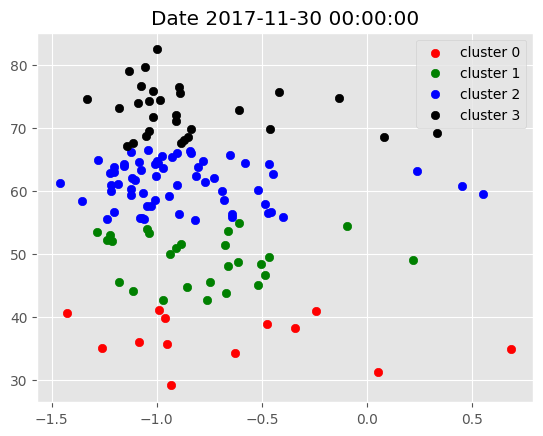

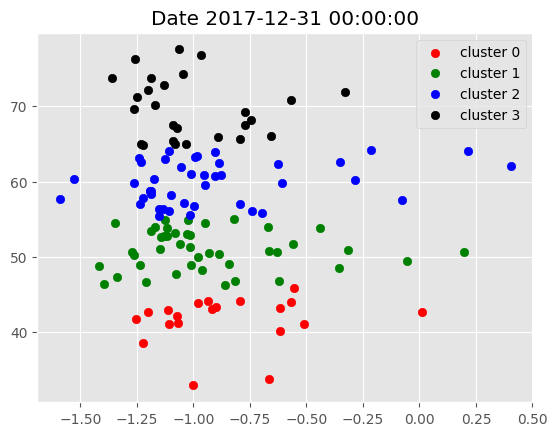

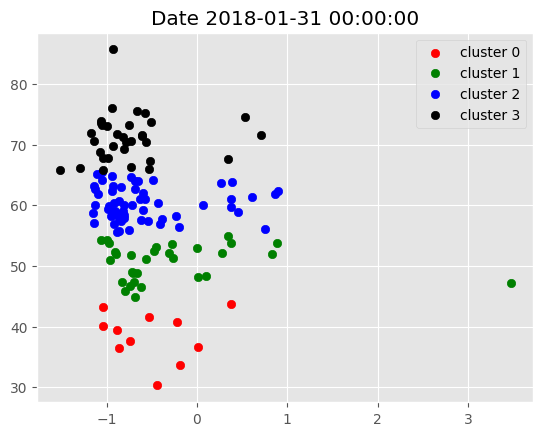

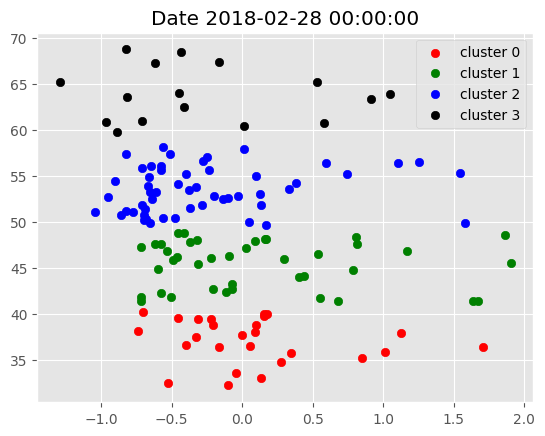

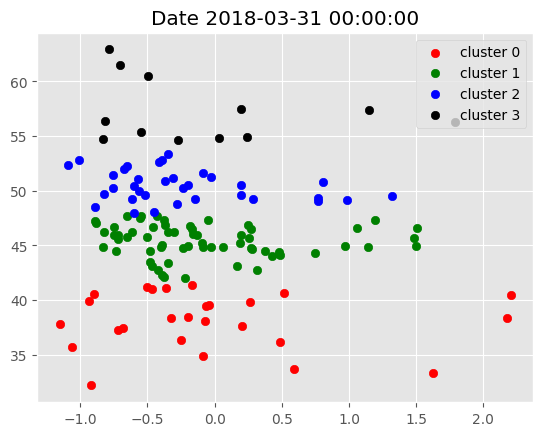

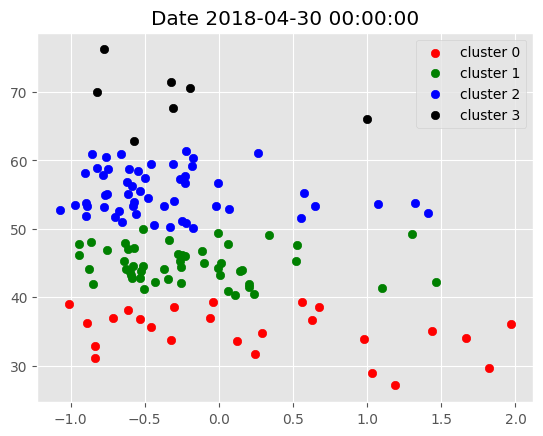

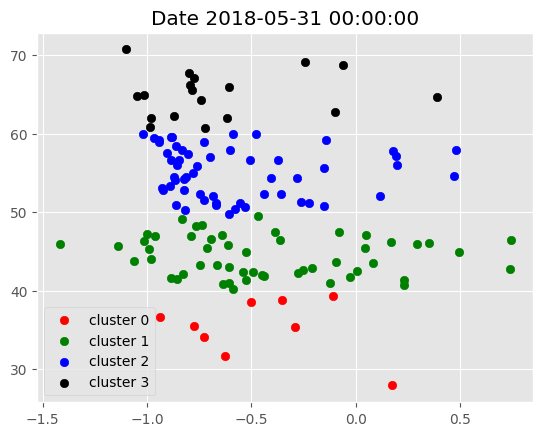

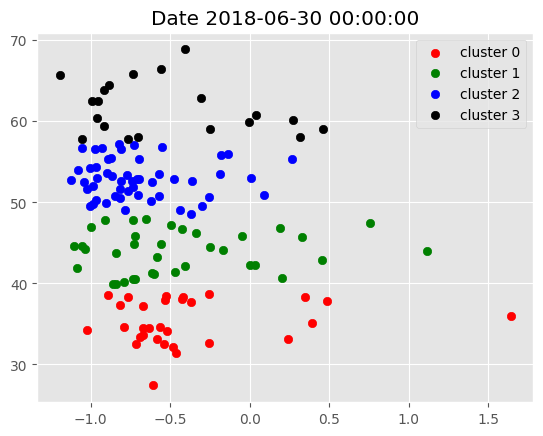

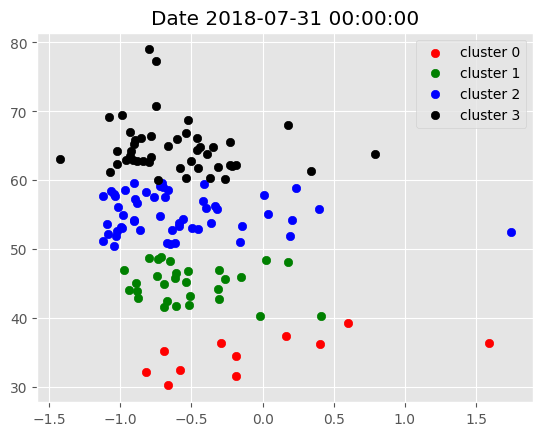

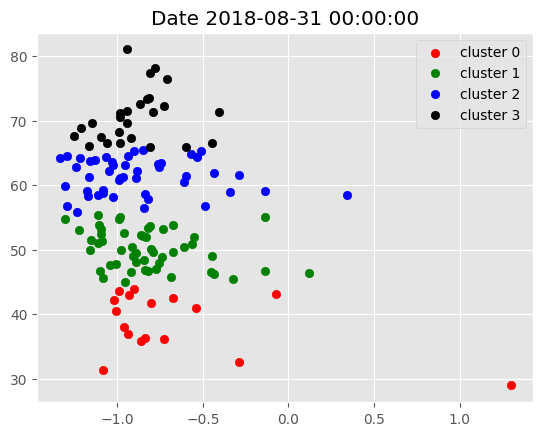

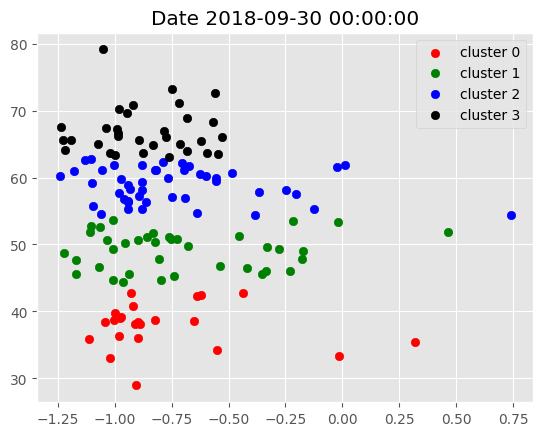

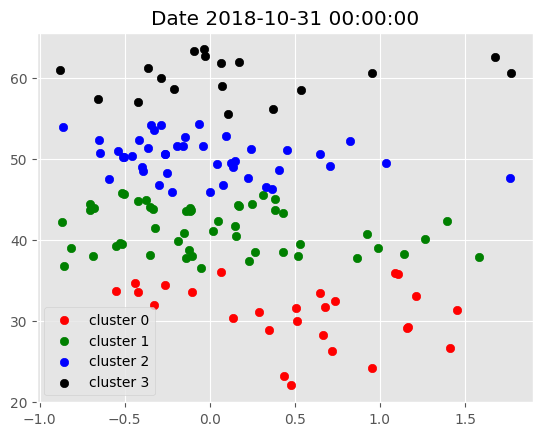

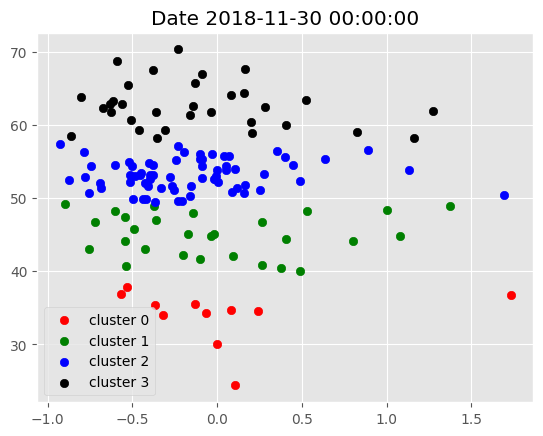

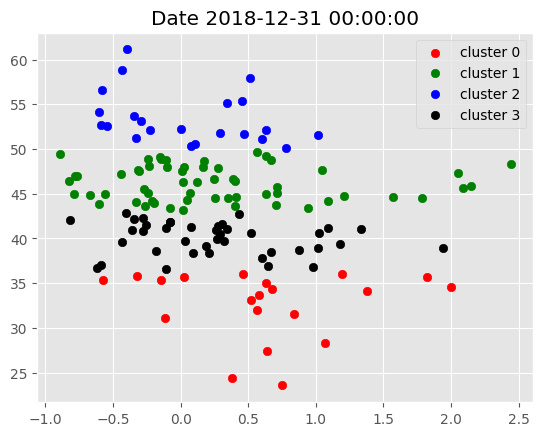

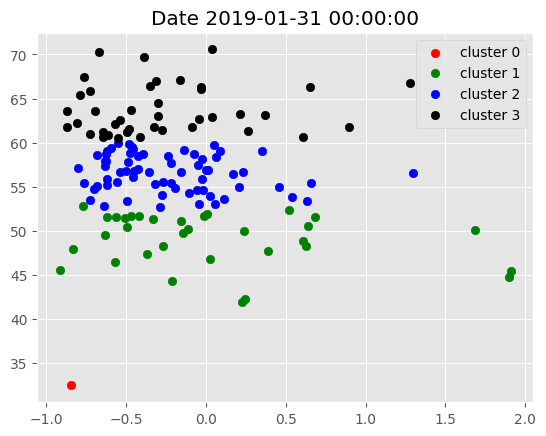

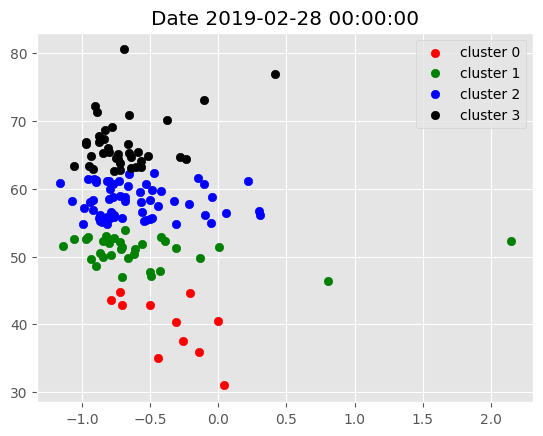

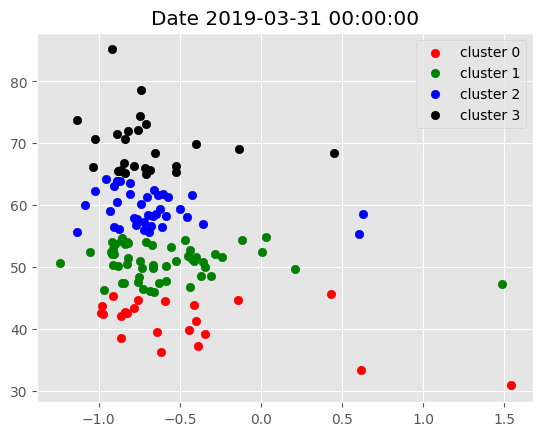

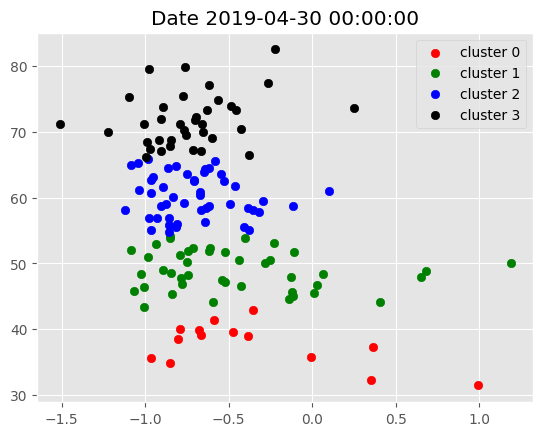

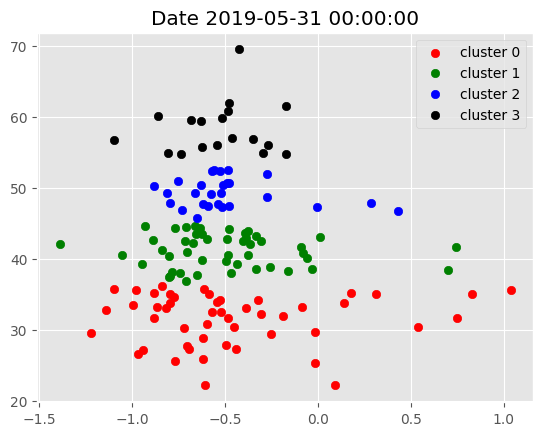

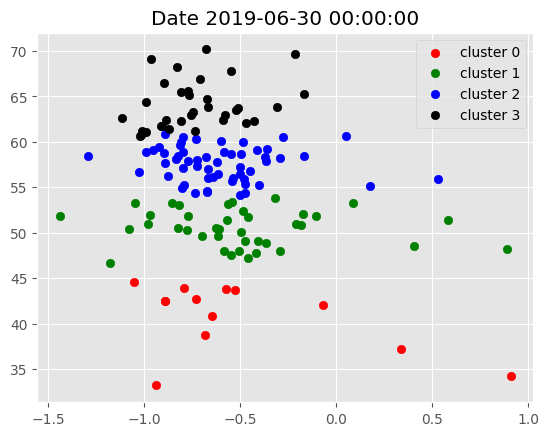

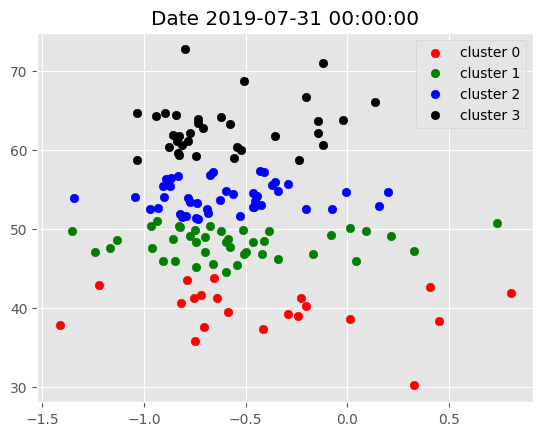

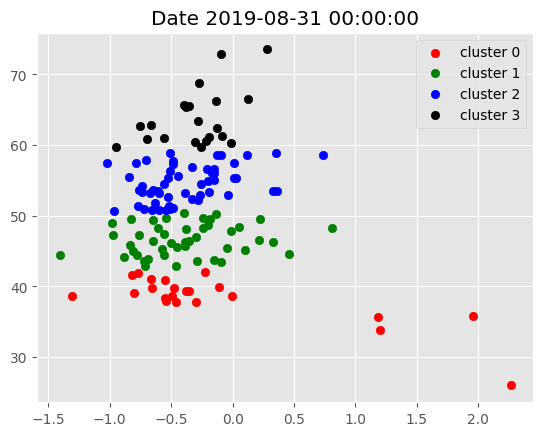

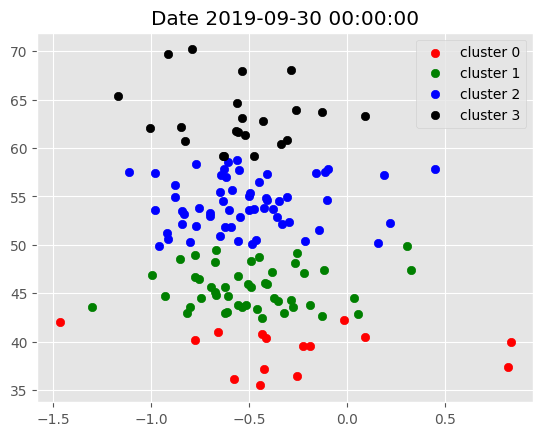

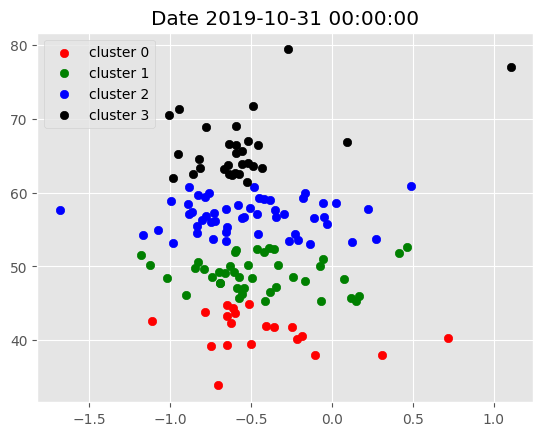

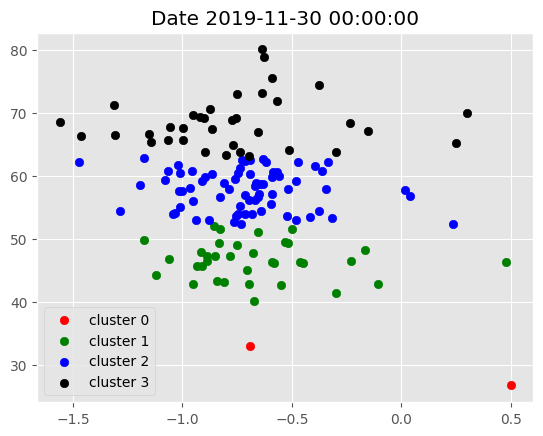

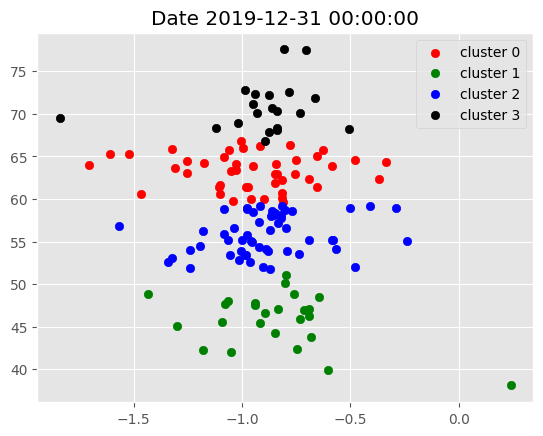

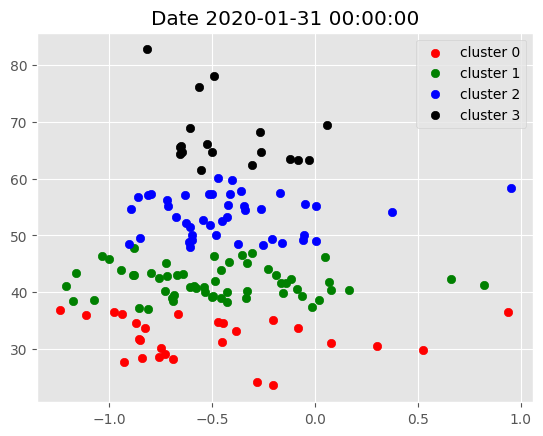

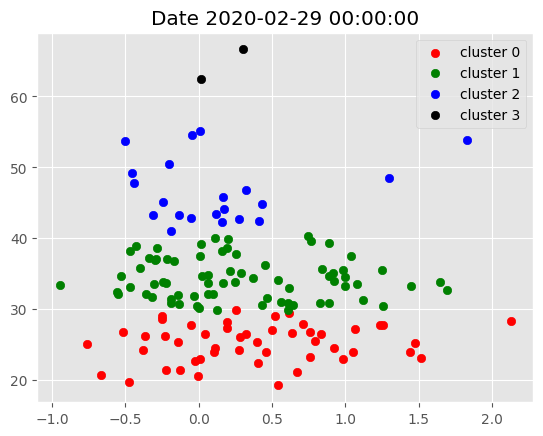

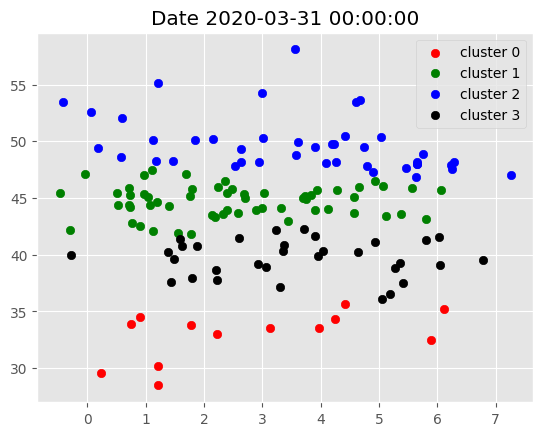

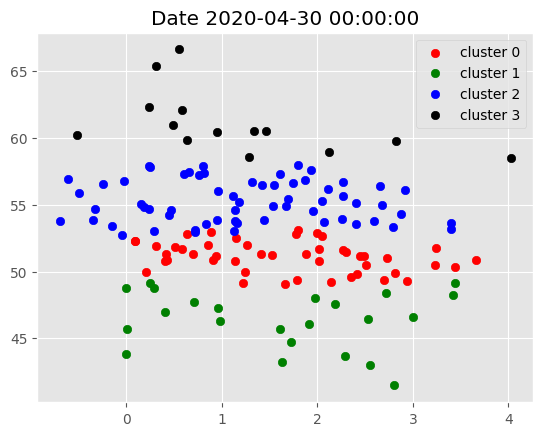

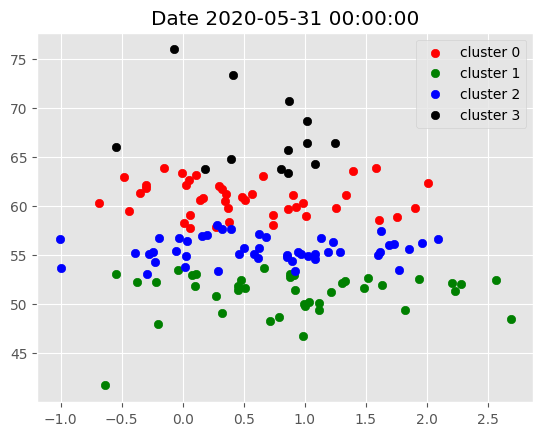

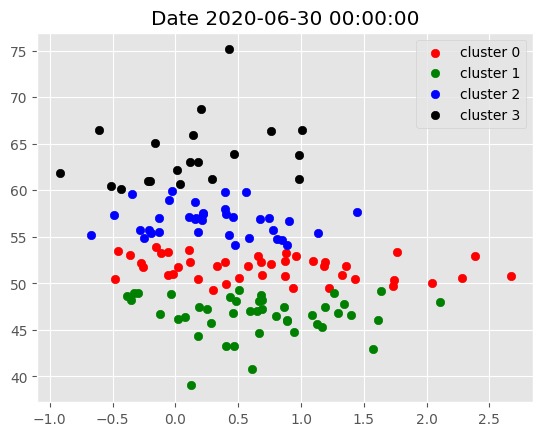

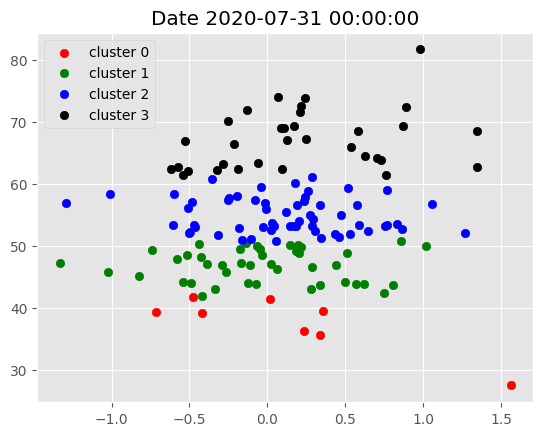

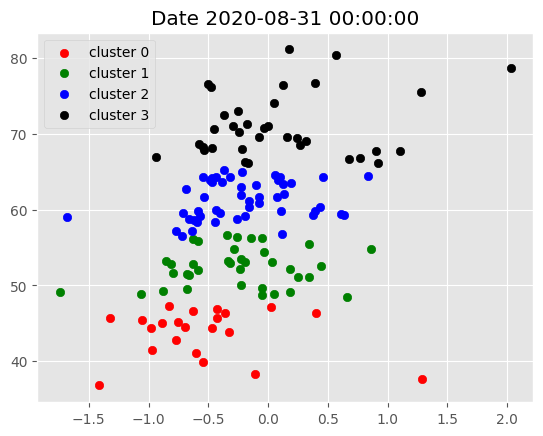

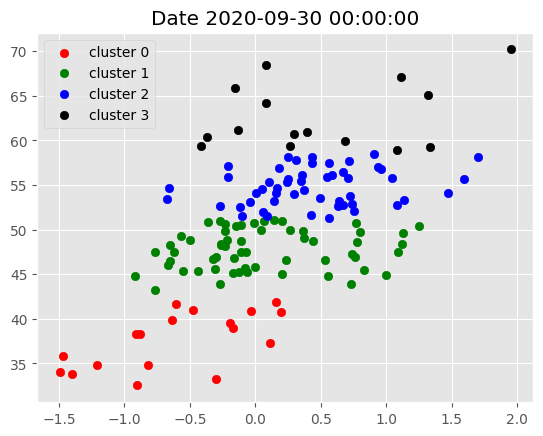

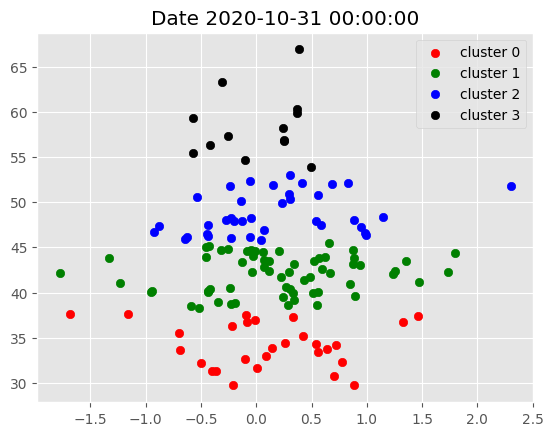

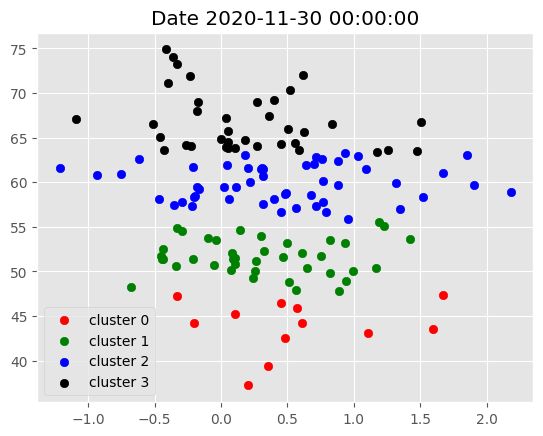

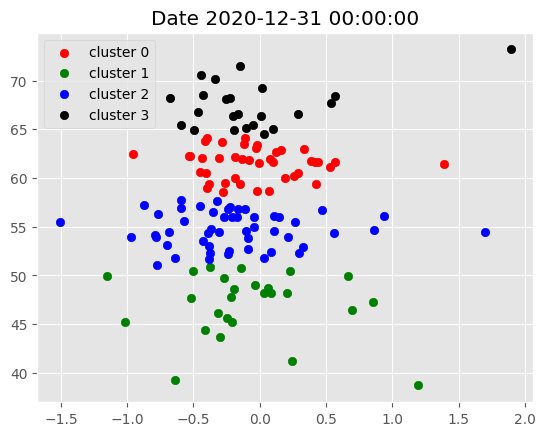

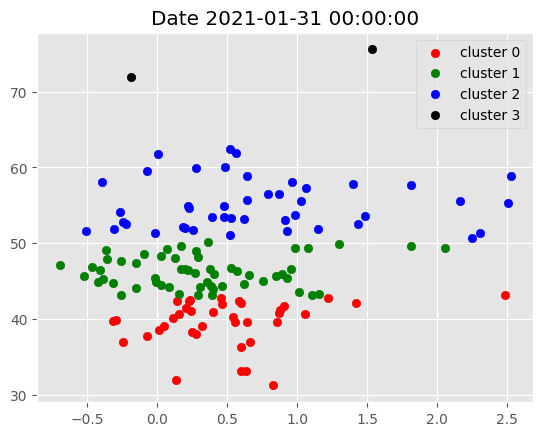

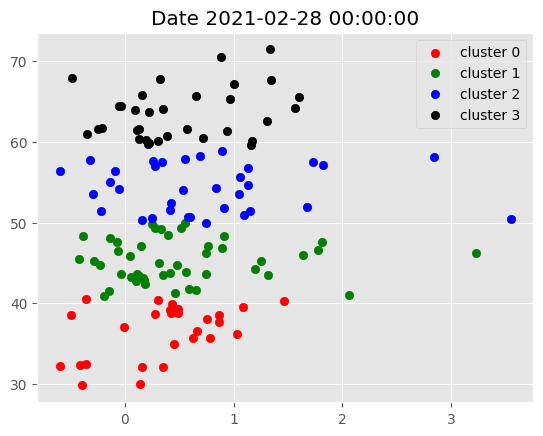

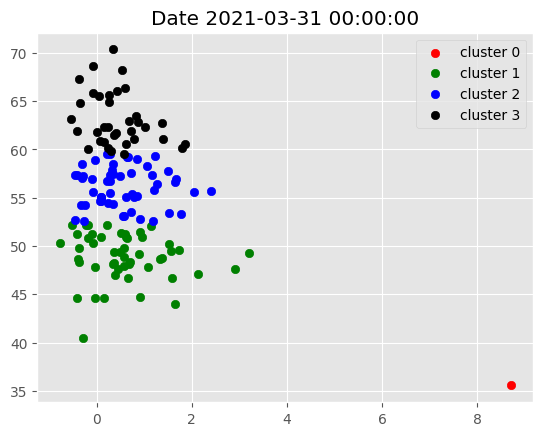

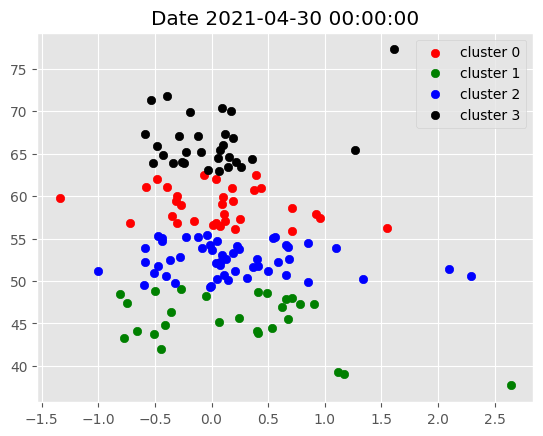

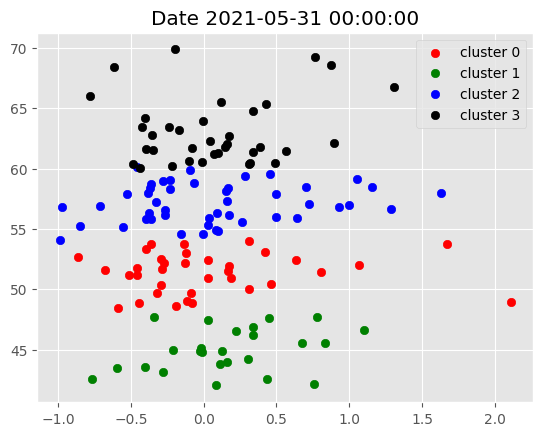

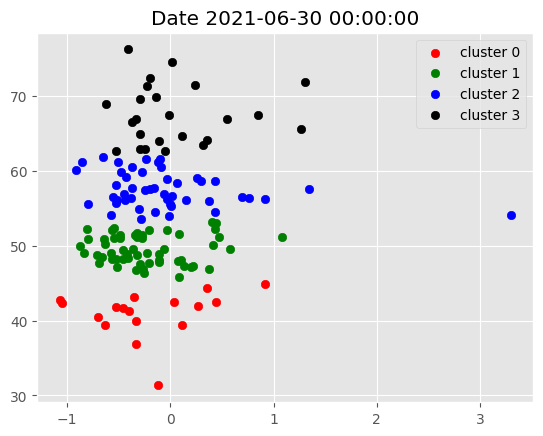

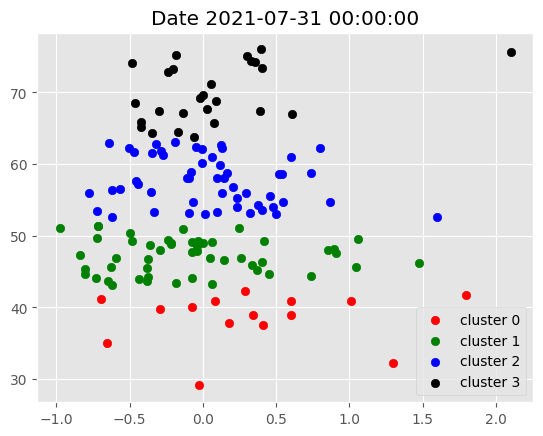

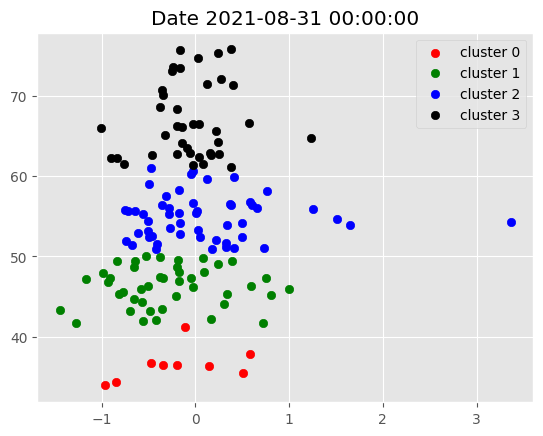

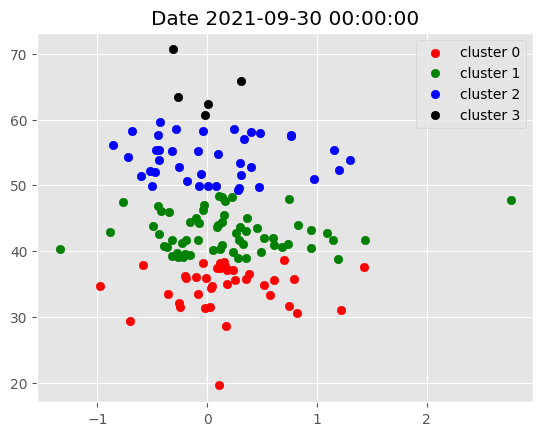

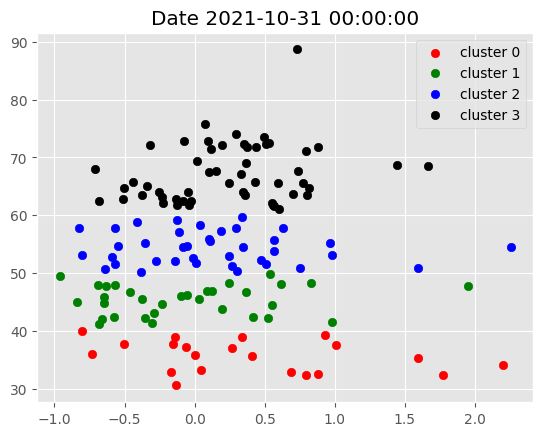

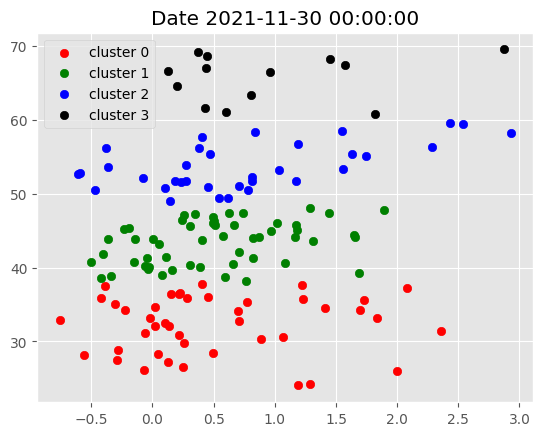

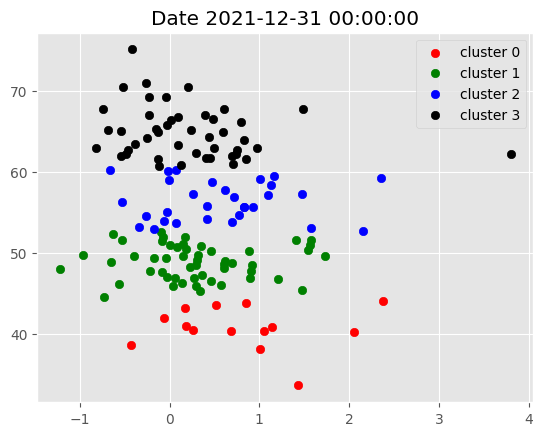

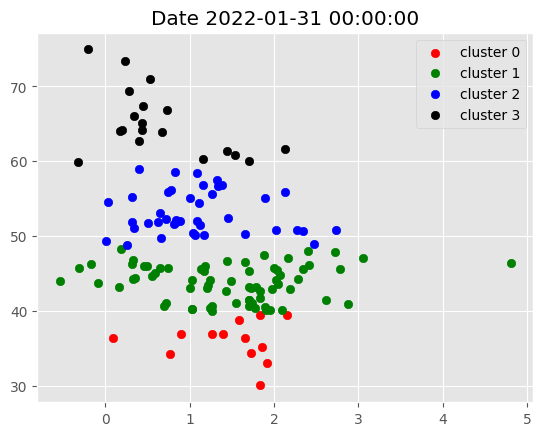

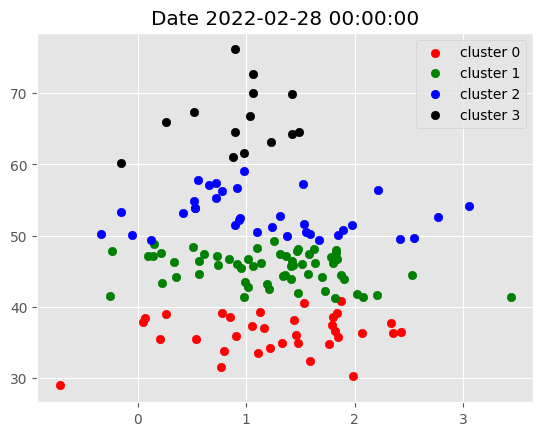

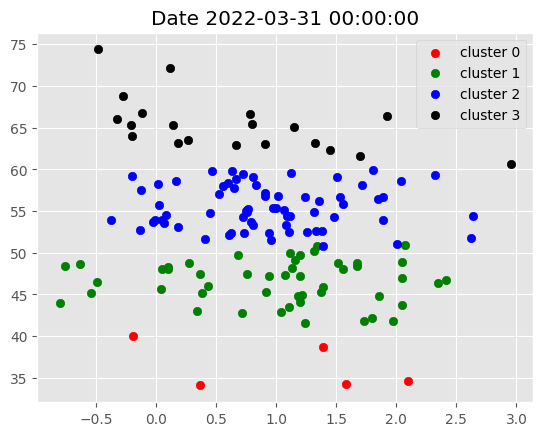

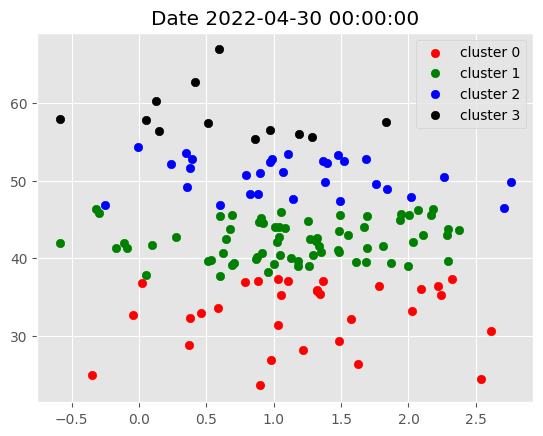

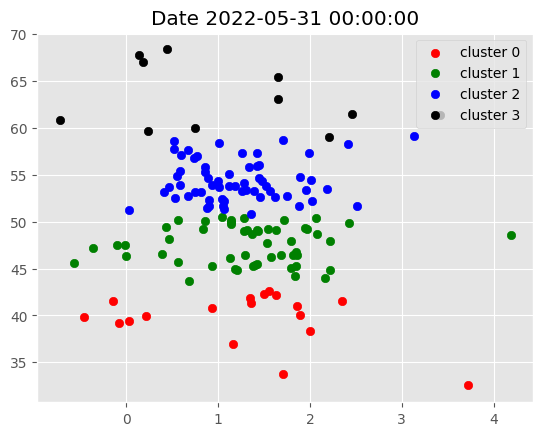

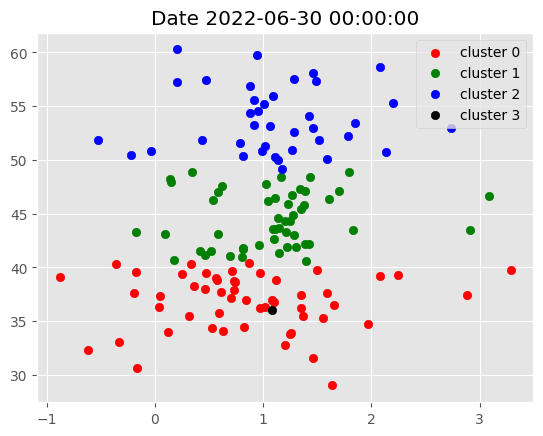

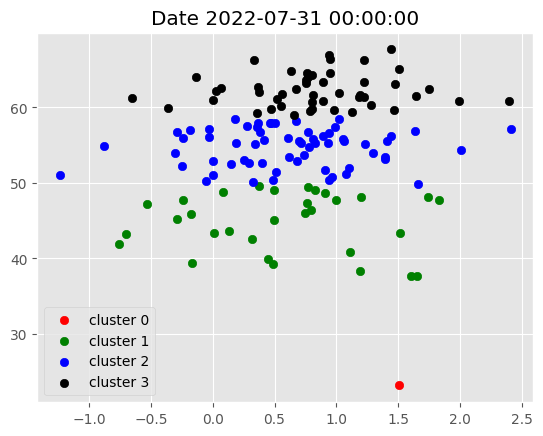

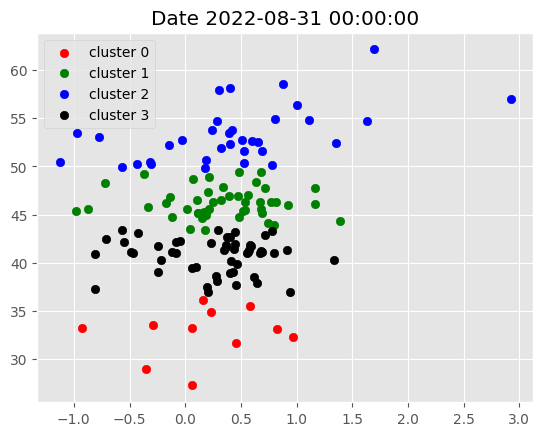

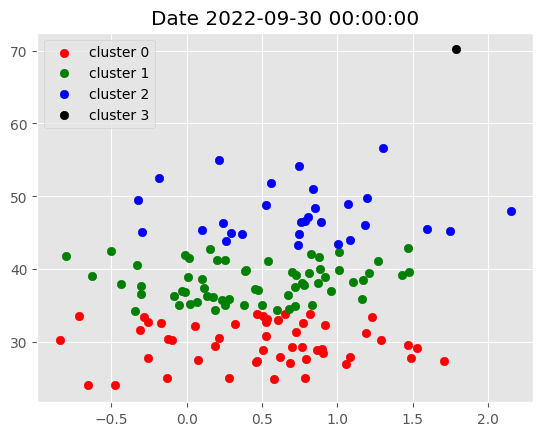

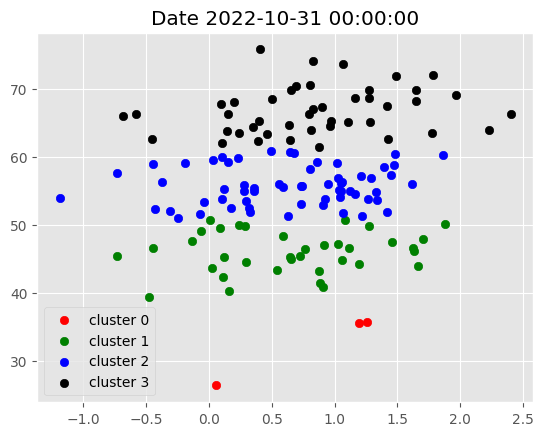

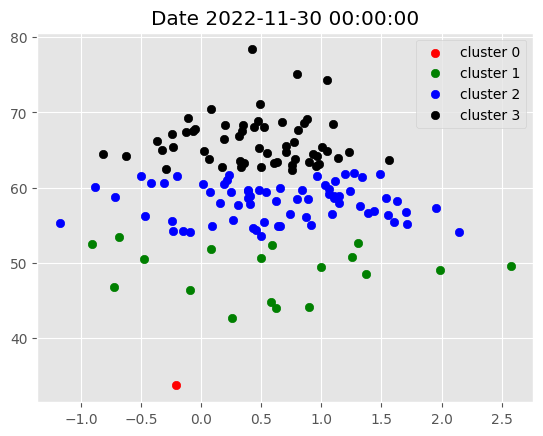

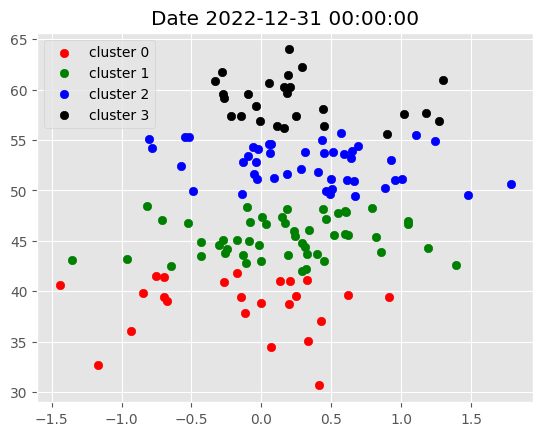

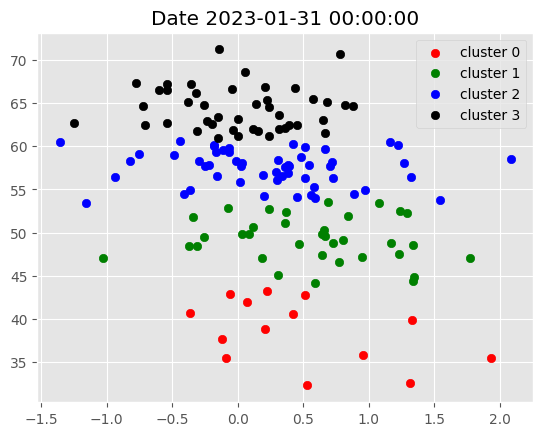

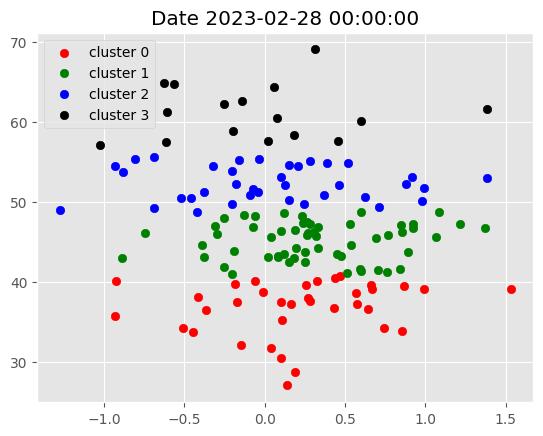

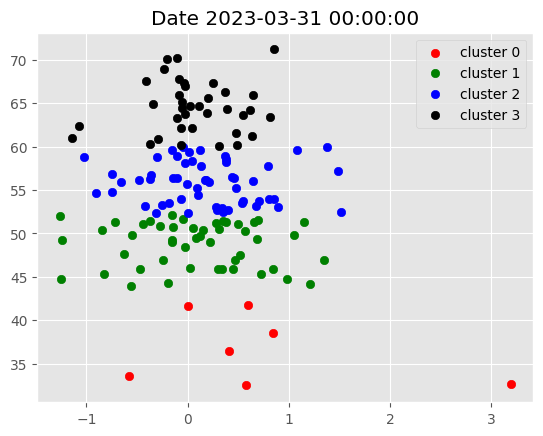

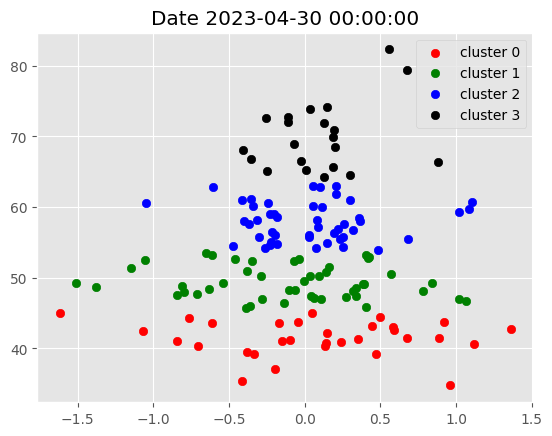

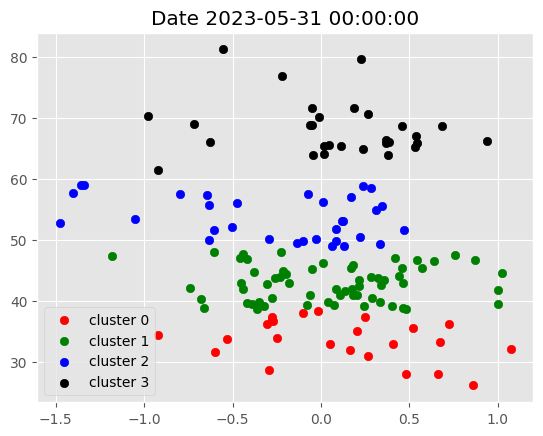

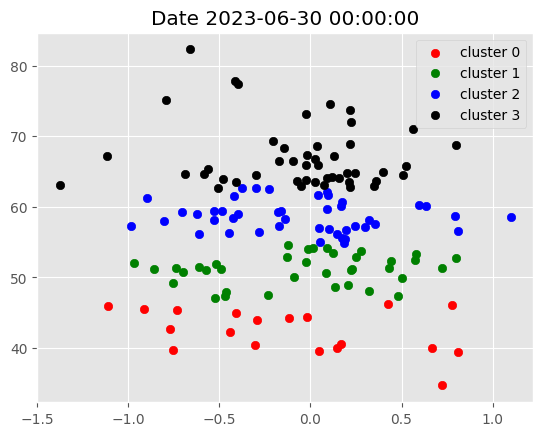

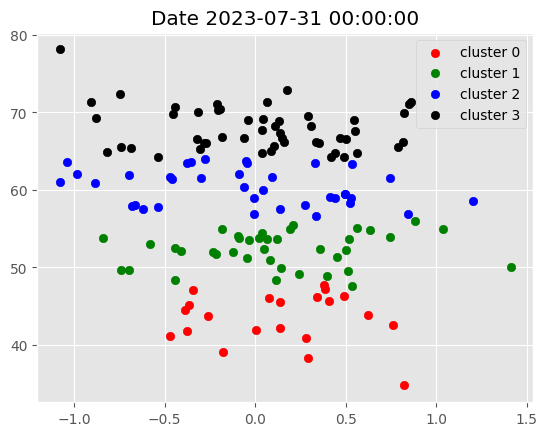

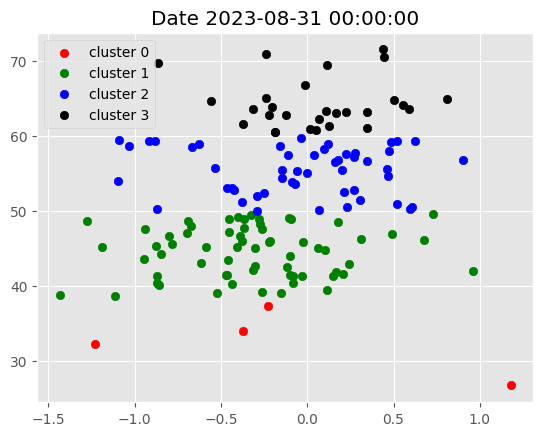

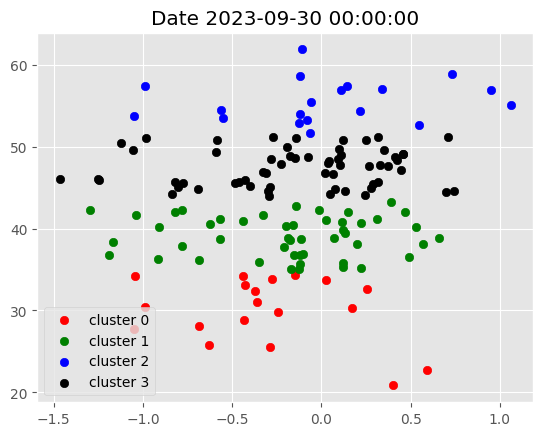

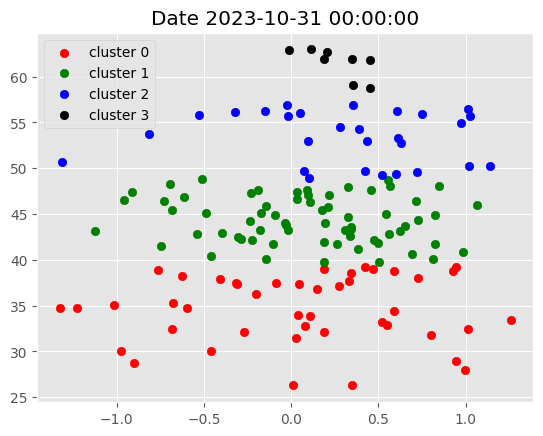

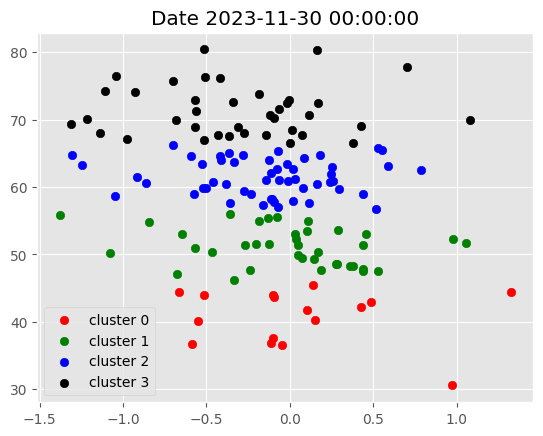

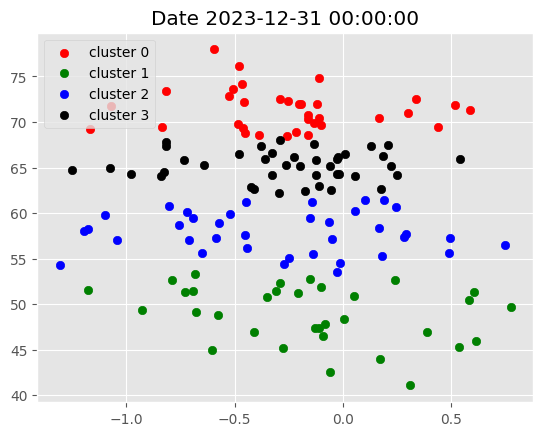

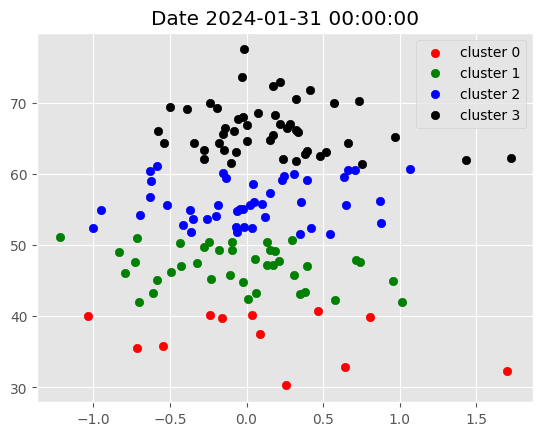

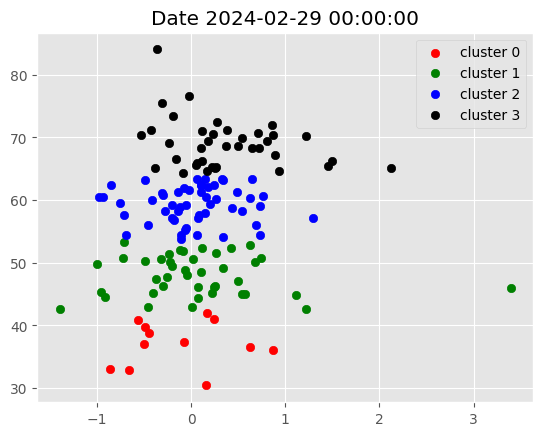

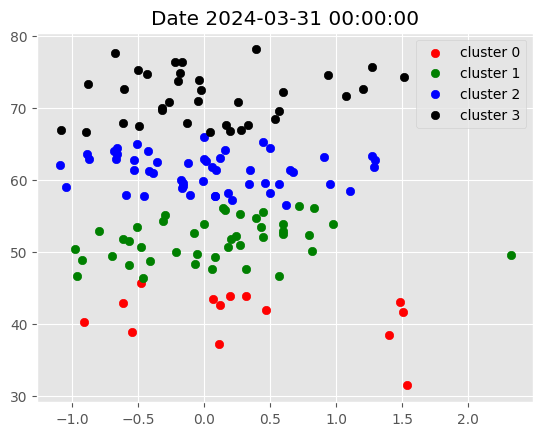

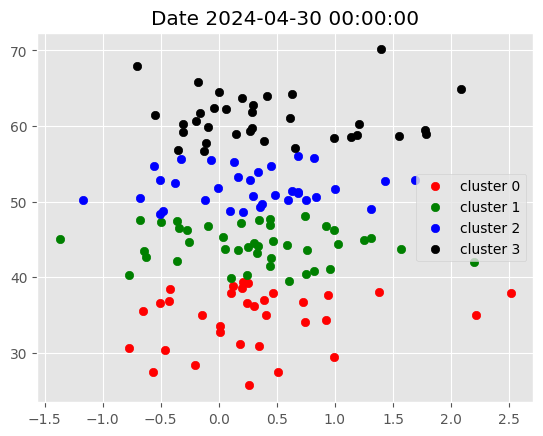

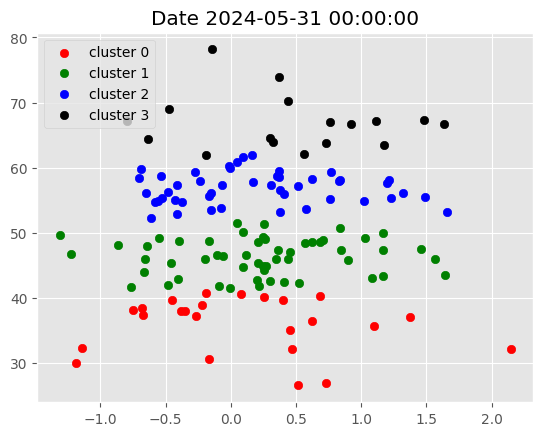

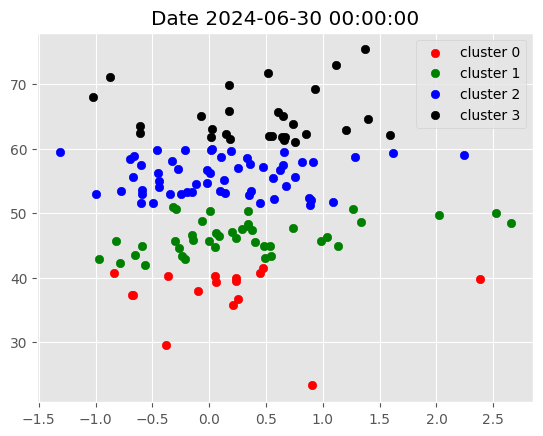

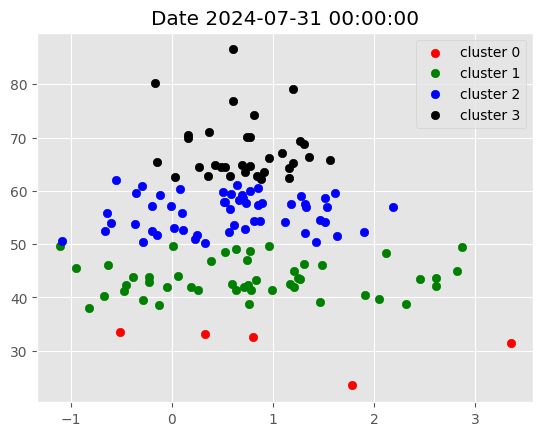

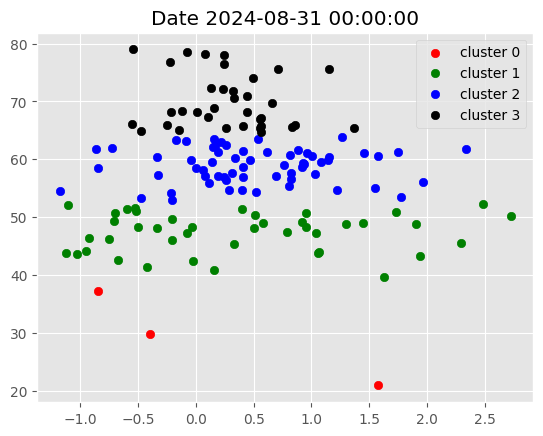

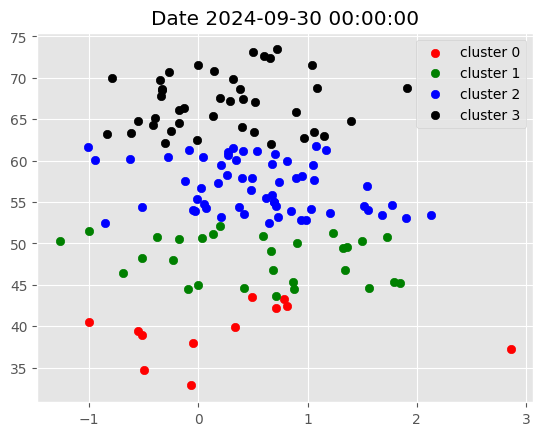

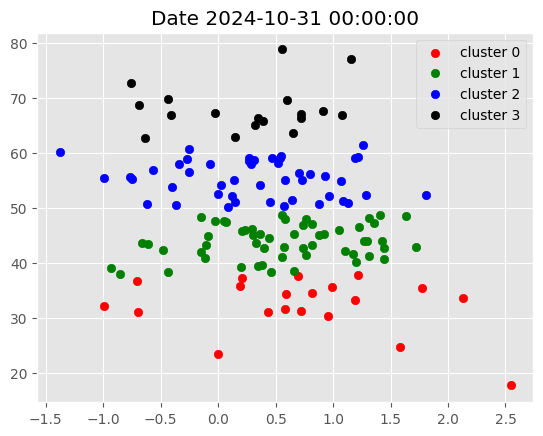

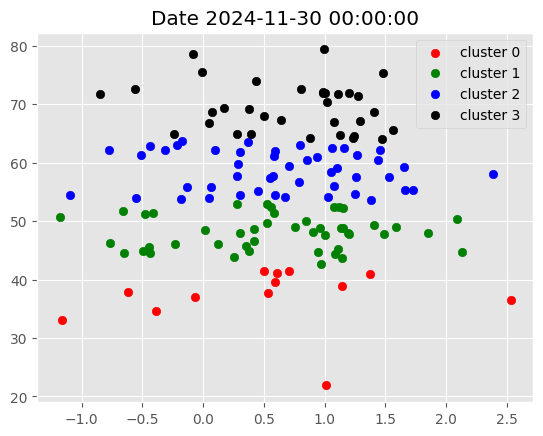

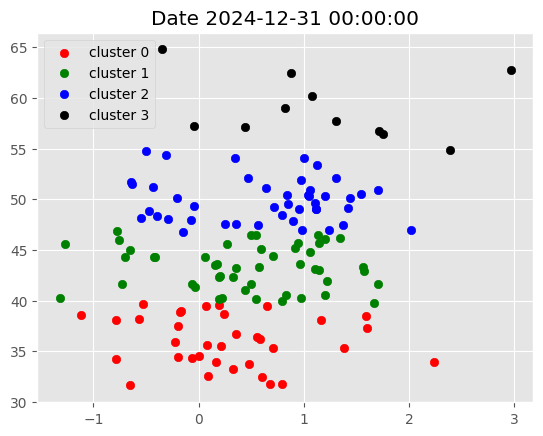

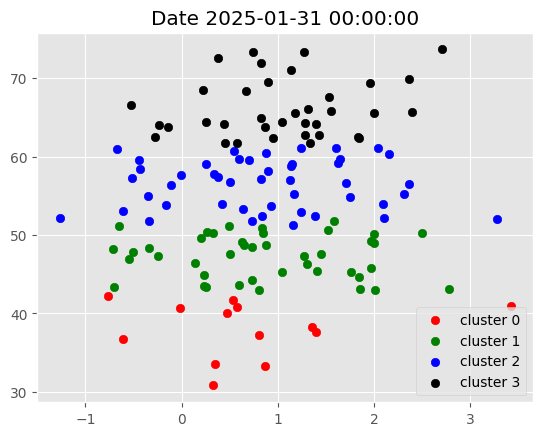

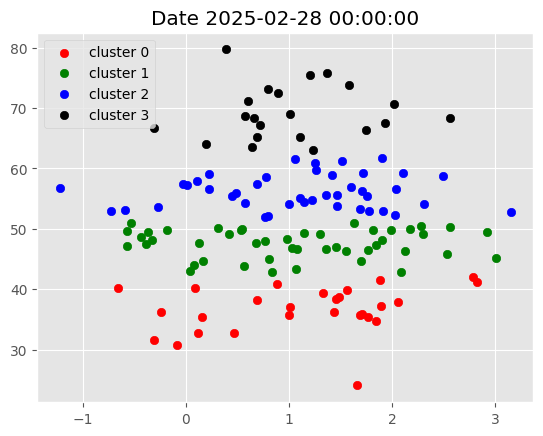

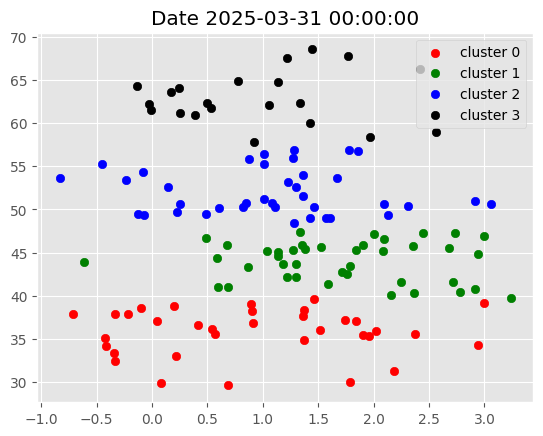

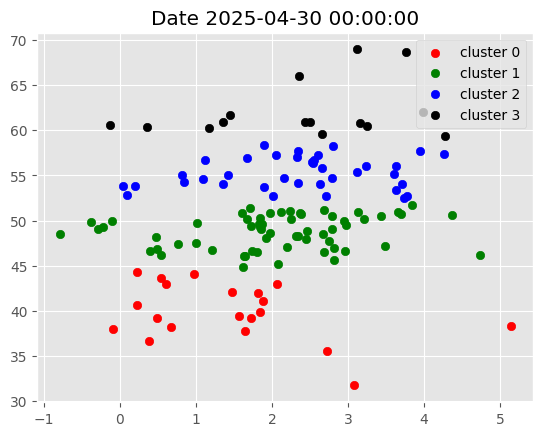

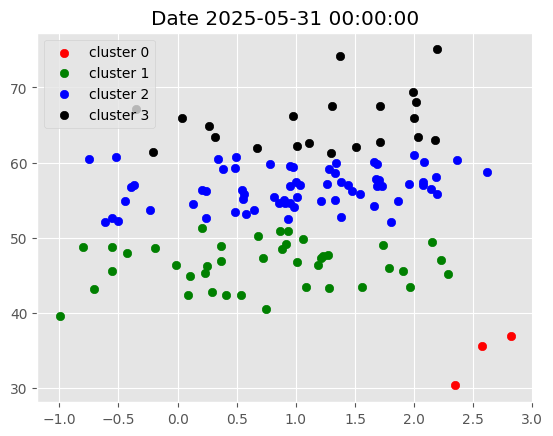

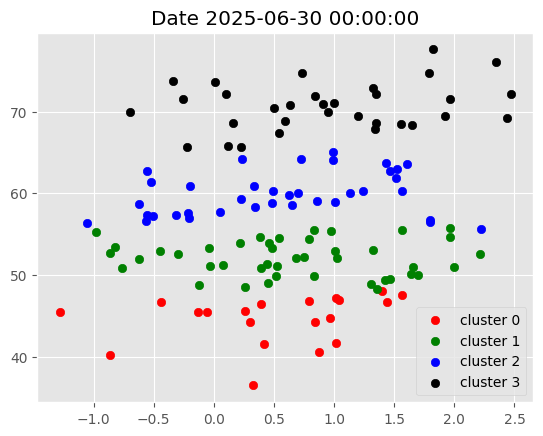

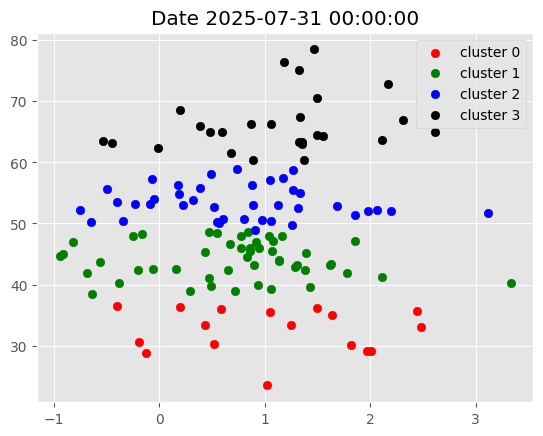

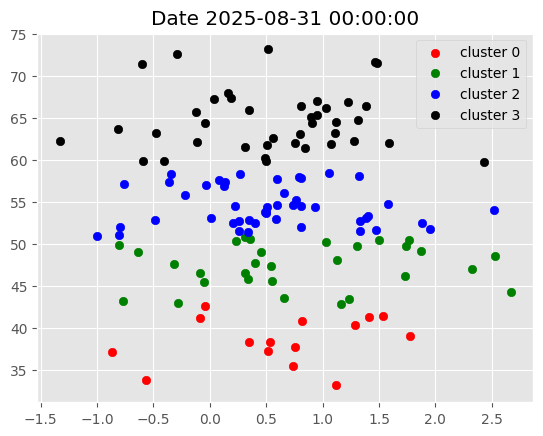

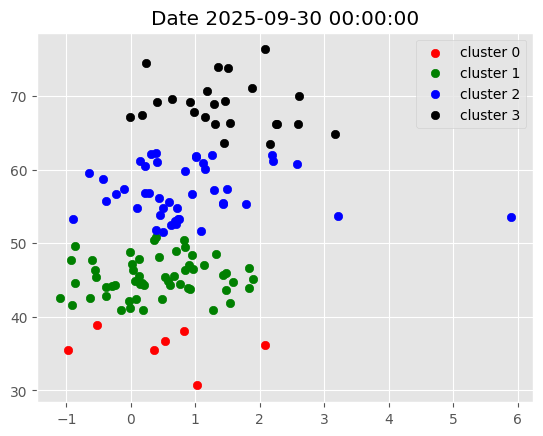

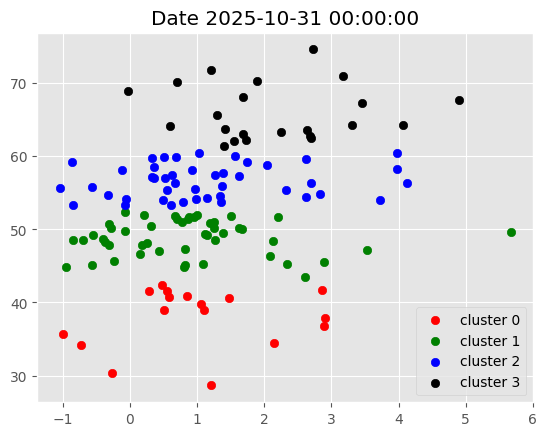

In [24]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max Sharpe Ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [25]:
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates

{'2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BLK',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NOC',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NOC',
  'NXPI',
  'PANW',
 

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the Sharpe Ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, .1), solver='SCS')
    weights = ef.max_sharpe(risk_free_rate=0.02)
    return ef.clean_weights()

* Download Fresh Daily Prices Data only for short listed stocks.

In [32]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust=False)

time.sleep(10)
new_df

[*********************100%***********************]  165 of 165 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2016-11-30   25.497940   41.666473         NaN   32.327560  104.032486   
2016-12-01   25.260311   40.542583         NaN   31.928467  102.490685   
2016-12-02   25.354908   40.727608         NaN   32.183201  102.168388   
2016-12-05   25.172649   41.707596         NaN   32.633266  102.542961   
2016-12-06   25.366438   42.228424         NaN   32.624767  103.143990   
...                ...         ...         ...         ...         ...   
2025-10-20  262.239990  232.059998  127.209999  129.509995  242.179993   
2025-10-21  262.769989  231.389999  128.559998  127.540001  250.509995   
2025-10-22  258.450012  228.679993  127.500000  127.949997  249.139999   
2025-10-23  259.579987  228.250000  127.349998  126.339996  249.809998   
2025-10-24  260.109985  228.000000  128.919998  127.849998  248.311996   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2016-11-30  102.809998   62.854229   79.364906   72.610001  50.418861  ...   
2016-12-01   99.510002   58.426319   79.158249   69.220001  51.039837  ...   
2016-12-02   99.730003   59.357632   78.720200   70.570000  50.753239  ...   
2016-12-05  101.949997   59.772472   79.389687   71.180000  51.127403  ...   
2016-12-06  101.550003   60.111122   79.348351   76.320000  51.367443  ...   
...                ...         ...         ...         ...        ...  ...   
2025-10-20  343.399994  246.220001  283.029999  307.950012  77.690002  ...   
2025-10-21  357.549988  246.369995  283.980011  310.570007  78.379997  ...   
2025-10-22  354.089996  240.360001  283.950012  308.149994  78.940002  ...   
2025-10-23  354.119995  243.289993  281.549988  309.839996  78.849998  ...   
2025-10-24  355.998596  242.350006  282.054993  313.600006  79.570000  ...   

Price         Volume                                                   \
Ticker           VLO     VRTX        VZ      WDAY       WDC       WFC   
Date                                                                    
2016-11-30  14238400  2292700  20698900   1678800   7121709  26567200   
2016-12-01  10720500  2662600  12982800   4472900   7287613  35623100   
2016-12-02   5295700  4580500  10650700  23153900   4626399  21894700   
2016-12-05   8277900  2588600  13074700   6189300   9083189  24793900   
2016-12-06   5149300  1816700  13581500   2572000   6680489  30706700   
...              ...      ...       ...       ...       ...       ...   
2025-10-20   1354000  1083500  28079200   2080900  10172200  15777200   
2025-10-21   1605200  1075900  29881700   2127800   4594400  20101100   
2025-10-22   3181400  1697200  31009500   1646300   9033800  18955000   
2025-10-23   4677600  1760900  52464000   1242500   7256700  14156000   
2025-10-24    315771    71583   5010881     80935   1199143   1343219   

Price                                             
Ticker           WMT     WYNN       XOM      XYZ  
Date                                              
2016-11-30  27978300  2618300  22696200  7805400  
2016-12-01  20549400  3881900  13005600  9372900  
2016-12-02  20022600  1955500   9706600  7325700  
2016-12-05  31583700  1678600  11741100  4764400  
2016-12-06  23334000  2892100  11293600  3093800  
...              ...      ...       ...      ...  
2025-10-20  10581200  2060000   9523600  4538200  
2025-10-21  10899700   836000   9202300  4362400  
2025-10-22  12296500  1109500  12938800  4609900  
2025-10-23  11392500  2114600  14997900  4688600  
2025-10-24   1202731   144889   1055739   613555  

[2238 rows x 990 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [33]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date_str in fixed_dates:
    try:
        start_date = pd.to_datetime(start_date_str)
        end_date_str = (start_date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date_str]
        optimization_start_date_str = (start_date - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date_str = (start_date - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # 2. Slice Optimization Data
        optimization_df = new_df['Adj Close'].loc[optimization_start_date_str:optimization_end_date_str, cols]
            
        # 3. Optimize Weights
        success = False
        weights = None
        
        # Calculate the lower bound here to be passed to optimize_weights
        calculated_lower_bound = round(1/(len(optimization_df.columns)*2), 4) # Increased precision
        
        try:
            # Pass the calculated lower bound
            weights_dict = optimize_weights(prices=optimization_df,
                                   lower_bound=calculated_lower_bound)

            # Correctly convert the dictionary of weights into a DataFrame.
            weights = pd.DataFrame(weights_dict, index=[0]) 
            weights = weights[cols]

            success = True
        
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date_str}. Continuing with Equal-Weights. Error: {e}')
        
        # 4. Handle Failed Optimization (Equal Weights)
        if not success:
            num_assets = len(cols)
            eq_weight = 1 / num_assets
            weights = pd.DataFrame(data=[eq_weight] * num_assets, 
                                   index=cols).T 
            weights.columns.name = None
            weights.index = [0]
        
        # 5. Slice and Merge Returns Data
        temp_returns = returns_dataframe.loc[start_date_str:end_date_str, cols].copy()

        # a) Stack returns (index: Date, Ticker)
        temp_df = temp_returns.stack().to_frame('return')
        temp_df.index.names = ['Date', 'ticker']

        # b) Stack weights (index: Ticker)
        weights_long = weights.stack().to_frame('weight').droplevel(0)
        weights_long.index.name = 'ticker'
        
        # c) Merge on the Ticker symbol
        temp_df = temp_df.reset_index(level='ticker').merge(
            weights_long,
            left_on='ticker',
            right_index=True
        ).set_index('ticker', append=True)
        
        # 6. Calculate Weighted Return
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        # 7. Concatenate Results
        if not temp_df.empty:
            portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(f"Error for {start_date_str}: {e}")
        
# Final Cleanup
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-05-01. Continuing with Equal-Weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2019-01-01. Continuing with Equal-Weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2020-03-01. Continuing with Equal-Weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2020-04-01. Continuing with Equal-Weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2021-02-01. Continuing with Equal-Weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2021-10-01. Continuing with Equal-W

,Strategy Return
Date,
2017-12-01,-0.005762
2017-12-04,0.004683
2017-12-05,-0.003507
2017-12-06,-0.001426
2017-12-07,0.005875
...,...
2025-10-20,0.015879
2025-10-21,-0.007480
2025-10-22,-0.003124


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [34]:
spy = yf.download(tickers='SPY', start='2015-01-01', end=dt.date.today(), auto_adjust=False)

spy_return = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

spy_return = spy_return.stack(future_stack=True).droplevel(1)

portfolio_df = portfolio_df.merge(spy_return, left_index=True, right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2017-12-01,-0.005762,-0.002078
2017-12-04,0.004683,-0.001211
2017-12-05,-0.003507,-0.003603
2017-12-06,-0.001426,0.000190
2017-12-07,0.005875,0.003148
...,...,...
2025-10-17,-0.005058,0.005660
2025-10-20,0.015879,0.010347
2025-10-21,-0.007480,-0.000015


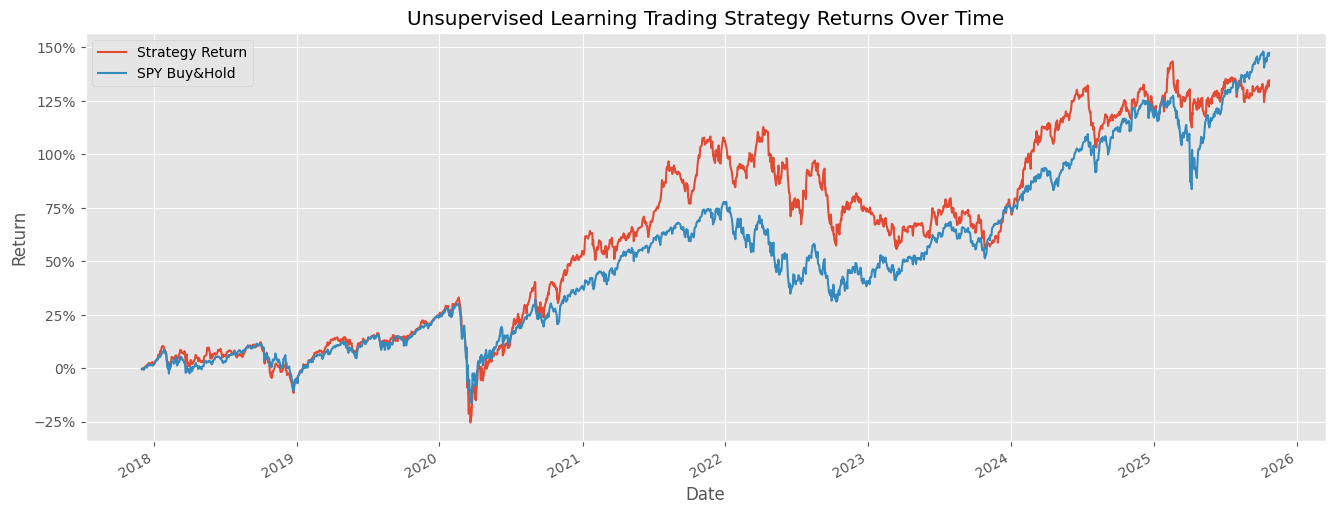

In [35]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return.plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()